# Menu

In [1]:
 ## definition du dossier drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports des librairies

In [2]:
!pip install pandas-profiling==2.7.1

     |████████████████████████████████| 256kB 5.3MB/s 
     |████████████████████████████████| 1.1MB 8.8MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 3.2MB 18.8MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 296kB 28.7MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=3c7d26a17e3fecbc174b8e6bb35f6a5879b918f033710fbdb05e39af8f9771c4
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=ff941c7334c871abb9a92e14c3260d7d4339c6f8eeb6b981ac71fbafc0a7533c
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.4.1 which is incompatible.
  Found existing ins

In [3]:
import pandas as pd
from pandas_profiling import ProfileReport
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.close('all')
from collections import Counter
from math import *
import time
import statsmodels.formula.api 
import statsmodels.api as sm
import seaborn as sns
import scipy
import scipy.stats as st
from scipy.stats import t, shapiro, ks_2samp
from statsmodels.stats.outliers_influence import variance_inflation_factor


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data_raw = pd.read_csv("/content/drive/My Drive//DataAnalyst/P7_Muller_Gauthier/data/data-projet7.csv")

# Definitions des fonctions

In [6]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

def describeall(df):
    df1 = df.describe(include = 'all')
    df1.loc['dtype'] = df.dtypes
    df1.loc['size'] = len(df)
    df1.loc['% 0'] = df.isnull().mean()
    df1.loc['% NaN'] = df.isna().mean()
    ##df1.loc['sum'] = df.sum()
    return df1

def G(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val
    
def smooth(x,y, box_percent=0.05,res=50,median=True):
    surface = max(x)-min(x)
    my_pas = np.arange(min(x),max(x),surface/res)
    box = surface*box_percent
    demi_box = box/2
    y_sortie = np.array([])
    x_sortie = np.array([])
    for myx in my_pas :
        temp = [y[i] for i in range(len(x)) if ((x[i]>=(myx-demi_box))and(x[i]<=(myx+demi_box)))]
        if median==True :
            temp_y = np.median(temp)
        else :
            temp_y = np.mean(temp)
        #print(temp_y)
        y_sortie = np.append(y_sortie,temp_y)
        #print(y_sortie)
        x_sortie = np.append(x_sortie,myx)
    return x_sortie, y_sortie
    
def lorenz (pays) : ## fonction qui calcul les valeurs de la courbes de  lorenz
    income = data2.loc[(data2['countryname']==pays)]['income'].values
    lorenz = np.cumsum(np.sort(income)) / income.sum()
    lorenz = np.append([0], lorenz)
    return lorenz

# Mission 1

##Imports des fichiers

In [7]:
data_raw = pd.read_csv("/content/drive/My Drive//DataAnalyst/P7_Muller_Gauthier/rendu/data-projet7.csv")

## Analyse des données

In [8]:
## Analyse du jeu de données
data_raw.profile_report()

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Nettoyage et préparation du jeu de données

In [9]:
## Preparation du jeu de données
## remplacement gdpppp Fidji ==> 
data_raw.loc[data_raw['country']=='FJI','gdpppp']=10771.44
## Ajout gdpppp kosovo 2008 ==>
data_raw.loc[data_raw['country']=='XKX','gdpppp']=7949.56
## Ajout gdpppp palestine 2009 ==>
data_raw.loc[data_raw['country']=='PSE','gdpppp']=4965.37

In [10]:
# Calcul du quantile manquant par la moyenne des quantiles autour
income_ltu_41 = data_raw.loc[(data_raw['country'] == 'LTU') & (data_raw['quantile'] == 42) |
        (data_raw['country'] == 'LTU') & (data_raw['quantile'] == 40),'income'].mean()
income_ltu_41

4882.14065

In [11]:
## Creation ligne 41 lituanie
ltu_41 = pd.DataFrame({'country' :  ['LTU'],'year_survey' : [2008], 'quantile' : [41],'nb_quantiles' : [100],'income' : [income_ltu_41],'gdpppp'  :  [17571.0]})

In [12]:
## Ajout ligne au df
data_raw=data_raw.append(ltu_41,ignore_index=True)
data_raw.sort_values(by=['country', 'quantile'], inplace=True)

In [13]:
data_raw.tail()

country  year_survey  quantile  nb_quantiles     income  gdpppp
11494     ZAF         2008        96           100  24553.568  9602.0
11495     ZAF         2008        97           100  28858.031  9602.0
11496     ZAF         2008        98           100  35750.290  9602.0
11497     ZAF         2008        99           100  46297.316  9602.0
11498     ZAF         2008       100           100  82408.550  9602.0

In [14]:
## Analyse du jeu de données
prof=data_raw.profile_report()
prof.to_file(output_file='/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/analyse_data_raw.html')


Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Mission 2

## Preparation des données

In [15]:
population = pd.read_csv('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/population_wb_2008.csv')

## Ajout de la population

In [16]:
data2=pd.merge(data_raw,population,how='left',left_on=['country'],right_on=['Country Code'])

In [17]:
data2[data2.isna().any(axis=1)]

country  year_survey  quantile  ...  Country Name  Country Code  Population 2008
10500     TWN         2008         1  ...        Taiwan           TWN              NaN
10501     TWN         2008         2  ...        Taiwan           TWN              NaN
10502     TWN         2008         3  ...        Taiwan           TWN              NaN
10503     TWN         2008         4  ...        Taiwan           TWN              NaN
10504     TWN         2008         5  ...        Taiwan           TWN              NaN
...       ...          ...       ...  ...           ...           ...              ...
10595     TWN         2008        96  ...        Taiwan           TWN              NaN
10596     TWN         2008        97  ...        Taiwan           TWN              NaN
10597     TWN         2008        98  ...        Taiwan           TWN              NaN
10598     TWN         2008        99  ...        Taiwan           TWN              NaN
10599     TWN         2008       100  ...        Taiwan           TWN              NaN

[100 rows x 9 columns]

In [18]:
## Ajout population taiwan 2008 = 23,037,000 link:https://countryeconomy.com/demography/population/taiwan?year=2008
data2.loc[data2['country']=='TWN','Population 2008']=23037000.00

In [19]:
## suppression et renommage des colonnes inutiles
data2.rename(columns={'Country Name':'countryname','Population 2008':'pop_2008'},inplace=True)
data2.drop(['Country Code','nb_quantiles'], axis = 1, inplace = True)

In [20]:
##Calcul de la population couverte par l'etude lien https://www.politologue.com/population-mondiale/ 
pop_monde_2008 = 6789771253.00
pop_2008 = data2.groupby(by=['countryname','pop_2008']).mean().reset_index()
pop_2008 = pop_2008['pop_2008'].sum()
pop = round(pop_2008/pop_monde_2008*100,2)
print("{}% de la popualtion mondiale de 2008 est couverte par l'etude".format(pop))

91.37% de la popualtion mondiale de 2008 est couverte par l'etude


## Indice de gini

In [21]:
## Calcul de l'indice de Gini pour chaques pays ~40 secondes
tic = time.time()
list_pays=data2['countryname'].unique() ## liste de chaque pays
id=0 
list_gini=[] ## creation d'une liste vierge pour indice de gini
for Pays in list_pays:
      v=data2.loc[(data2['countryname']==Pays)]['income']
      bins, result, gini_val = G(v)
      for i in range(100) :
        list_gini.append(gini_val) ## ajoute en fin de liste l'indice
toc = time.time()
print(str(toc - tic)+" seconds")

0.9050576686859131 seconds


In [22]:
## ajout liste pays au dataframe
data2['gini']=pd.Series(list_gini)

In [23]:
prof = data2.profile_report()
prof.to_file(output_file='/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/analyse_data2.html')

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Etude

In [24]:
## Aggregation par pays
data2_agg = data2.groupby(by=['country','countryname','pop_2008']).mean().reset_index()

In [25]:
## Liste des pays etudiés
liste_pays_etud = ['France','Afrique du Sud','Fédération de Russie','Nigéria','Chine','Brésil','Inde','Norvège']

### representation graphique 

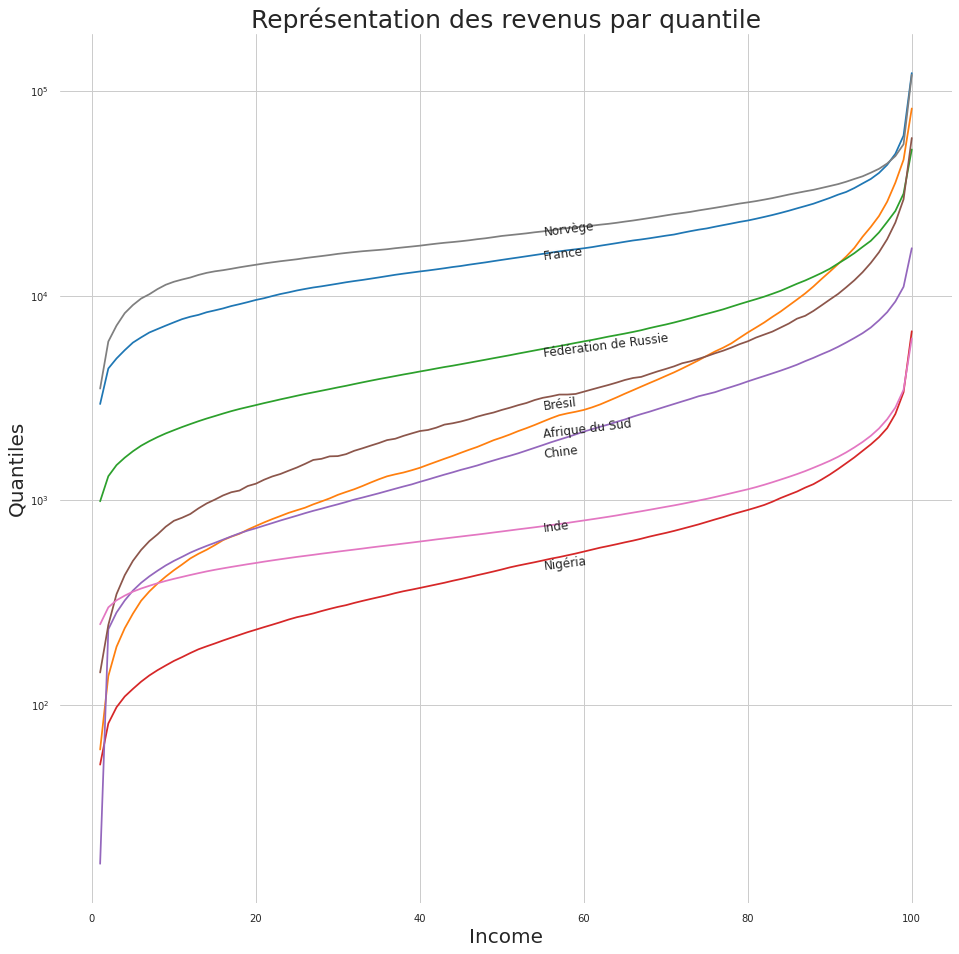

In [26]:
##Représentation des revenus par quantile sur echelle logarythme
fig = plt.figure(figsize=(16, 16))
## Tracé + legende pour chaque pays
for pays in liste_pays_etud:
  x = data2.loc[(data2['countryname']==pays)]['quantile']
  y = data2.loc[(data2['countryname']==pays)]['income']

  plt.plot(x,y)
  ## nom pays au point ( 50, income[quantile == 50])
  val_text =  data2.loc[(data2['countryname']==pays) & (data2['quantile']==50)]['income']
  plt.text(55, val_text.iloc[0] , pays, fontsize = '12', rotation = 7)

## Parametre du graphique
plt.grid()
plt.yscale("log")
plt.xlabel("Income",fontsize=20)
plt.ylabel("Quantiles",fontsize=20)
plt.title('Représentation des revenus par quantile',fontsize=25)
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/Représentation des revenus par quantile.png')
plt.show()


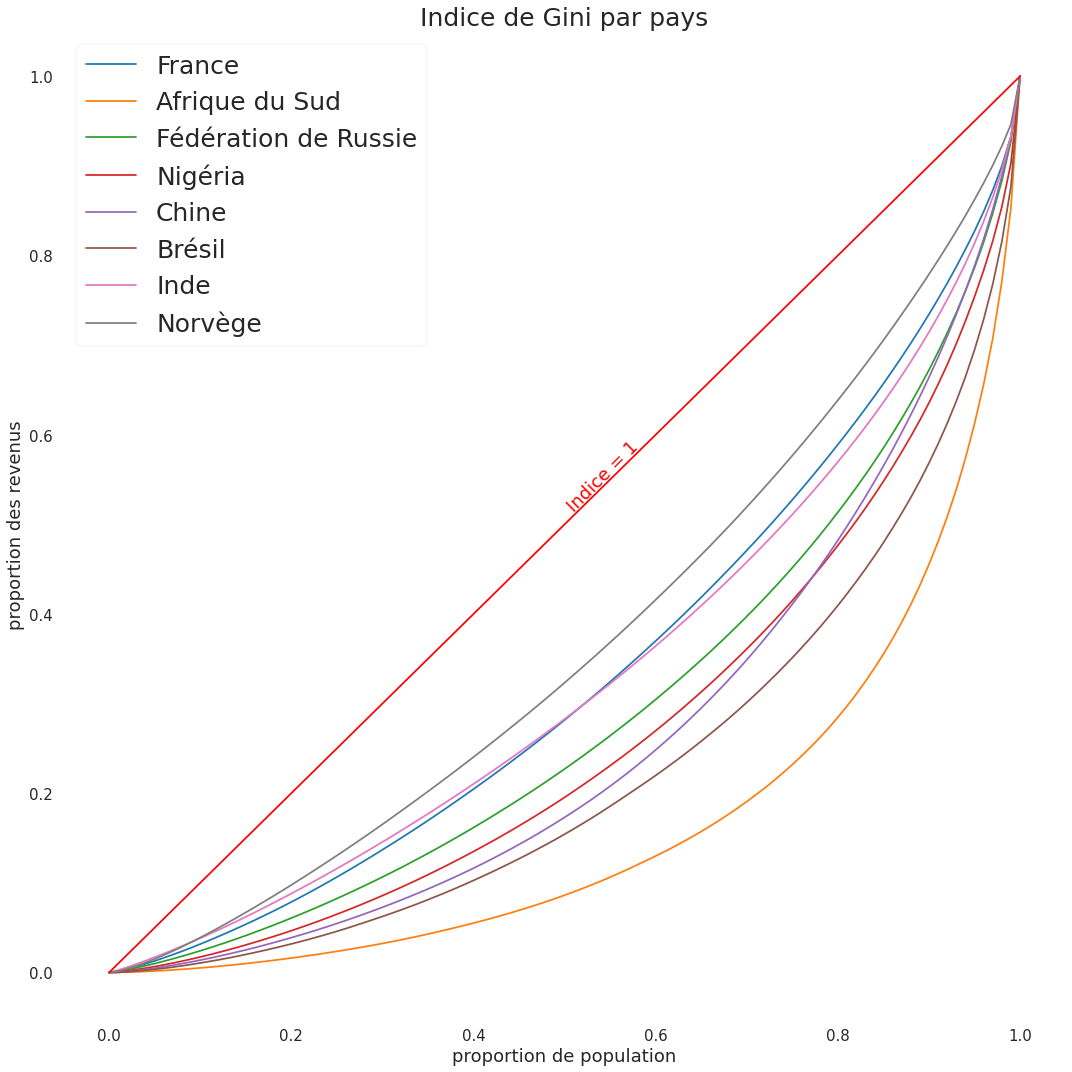

In [27]:
## Representation graphique de l'indice de gini
plt.figure(figsize=(15,15))

# Tracé + legende pour chaque pays avec fonction lorenz()
for pays in liste_pays_etud:
  x = np.linspace(0,1,len(lorenz(pays)))
  y = lorenz(pays)
  plt.plot(x,y)

# Paramètre de la droite
x = [0, 1]
y = [0, 1]
plt.plot(x, y, 'red')
plt.text(0.5, 0.515, 'Indice = 1', fontsize=18, rotation = 45, color ='red')

## Parametre du graphique
plt.title('Indice de Gini par pays', fontsize=25)
plt.ylabel('proportion des revenus', fontsize=18)
plt.yticks(fontsize=15)
plt.xlabel('proportion de population', fontsize=18)
plt.xticks(fontsize=15)
plt.legend(liste_pays_etud, prop={'size':25})
plt.tight_layout()
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/Indice de gini.png')
plt.show()

###Evolution indice de gini

Graphiqe fait a partir de Power BI, disponible dans le dossier rendu

In [28]:
## Prepraration des données
evol_gini = pd.read_csv('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/worldbank/data_gini_wb.csv')

In [29]:
evol_gini = pd.merge(data2_agg[['country','countryname']],evol_gini,how='left',left_on=['country'],right_on=['Country Code'])

In [30]:
#Top 5 des pays les moins egalitaire
data2_agg[["countryname","gini"]].sort_values(by='gini',ascending=False).head(5)

countryname      gini
115  Afrique du Sud  0.648877
41         Honduras  0.580877
21         Colombie  0.550541
40        Guatemala  0.546190
11          Bolivie  0.543095

In [31]:
## Top 5 des pays les plus egalitaire
data2_agg[["countryname","gini"]].sort_values(by='gini',ascending=False).tail(5)

countryname      gini
108              Ukraine  0.250070
98                 Suède  0.249447
24    République tchèque  0.246703
96   République slovaque  0.241981
97              Slovénie  0.226034

In [32]:
##Moyenne de l'indice de gini sur les 116 pays etudié
data2_agg['gini'].mean()

0.3691808035431845

In [33]:
## Classement de la France
data_fr = data2_agg[["countryname","gini"]].sort_values(by='gini')
data_fr.loc[(data_fr['countryname']=='France')].reset_index()

index countryname      gini
0     34      France  0.320295

# Mission 3

## Modification des fichiers

In [34]:
## Import du fichier Elasticité
elas_raw = pd.read_csv('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/elas2018.csv')

In [35]:
## Creation d'un df par pays des coeff d'elasticité
elas_wb=elas_raw[['iso3','region','IGEincome']]
elas_wb=elas_wb.groupby(['iso3','region'])['IGEincome'].mean()
elas_wb=elas_wb.reset_index()

In [36]:
## Creation d'un df avec les valeurs du fichier Elas.txt
elas_extra = pd.DataFrame({'region': ['Latin America & Caribbean', 'Middle East & North Africa', 'Sub-Saharan Africa', 'High income','South Asia','Europe & Central Asia','East Asia & Pacific'],
                   'ige_extra': [0.66,0.66, 0.66,0.4,0.5,0.4,0.4]})

In [37]:
## Jointure 
elas=pd.merge(elas_wb,elas_extra,how='inner',on='region',sort = False)

In [39]:
## remplamcment des NaN par la valeur ige_extra
elas.IGEincome.fillna(elas.ige_extra,inplace= True)
del elas['ige_extra']

In [40]:
data_complet=pd.merge(data2,elas,how='left',left_on=['country'],right_on=['iso3'])

In [41]:
data_complet.loc[data_complet['IGEincome'].isnull()]

country  year_survey  quantile  ...  iso3  region IGEincome
10000     SYR         2004         1  ...   NaN     NaN       NaN
10001     SYR         2004         2  ...   NaN     NaN       NaN
10002     SYR         2004         3  ...   NaN     NaN       NaN
10003     SYR         2004         4  ...   NaN     NaN       NaN
10004     SYR         2004         5  ...   NaN     NaN       NaN
...       ...          ...       ...  ...   ...     ...       ...
11395     XKX         2008        96  ...   NaN     NaN       NaN
11396     XKX         2008        97  ...   NaN     NaN       NaN
11397     XKX         2008        98  ...   NaN     NaN       NaN
11398     XKX         2008        99  ...   NaN     NaN       NaN
11399     XKX         2008       100  ...   NaN     NaN       NaN

[200 rows x 11 columns]

In [42]:
## Ajout des informations manquante 
data_complet.loc[data_complet['country']=='XKX','IGEincome']=0.4
data_complet.loc[data_complet['country']=='XKX','iso3']='XKX'
data_complet.loc[data_complet['country']=='XKX','countryname']='Kosovo'
data_complet.loc[data_complet['country']=='XKX','region']='Europe & Central Asia'
data_complet.loc[data_complet['country']=='SYR','IGEincome']=0.66
data_complet.loc[data_complet['country']=='SYR','iso3']='SYR'
data_complet.loc[data_complet['country']=='SYR','countryname']='Syrie'
data_complet.loc[data_complet['country']=='SYR','region']='Middle East & North Africa'

In [43]:
data_complet=data_complet[['countryname','quantile','gdpppp','income','IGEincome','gini']].reset_index().set_index('index')
data_complet.rename(columns={'countryname':'nom_pays','quantile':'C_i_child','IGEincome':'pj'},inplace=True)

In [44]:
data_complet['income']=round(data_complet['income'],2)
data_complet['gdpppp']=round(data_complet['gdpppp'],2)
data_complet['pj']=round(data_complet['pj'],3)

In [45]:
data_complet.dtypes

nom_pays      object
C_i_child      int64
gdpppp       float64
income       float64
pj           float64
gini         float64
dtype: object

## Création d'un echantillon 500x

In [46]:
data_total=data_complet.reindex(np.repeat(data_complet.index.values,500)).reset_index()
data_total['C_i_parents']=0
data_total.drop(['index'],axis=1,inplace=True)

## Calcul des probabilité  des classes parents

In [47]:
## configuration des types de variable
data_total['C_i_child']=data_total['C_i_child'].astype(np.int8)
data_total['income']=data_total['income'].astype(np.float64)
data_total['pj']=data_total['pj'].astype(np.float64)
data_total['gdpppp']=data_total['gdpppp'].astype(np.float64)
data_total['C_i_parents']=data_total['C_i_parents'].astype(np.int8)
data_total['nom_pays']=data_total['nom_pays'].astype('category')


In [48]:
## Creation d'une liste avec les probabilités /!\ Prevoir ~ 10 mins /!\ 
tic = time.time()
list_pays=data_total['nom_pays'].unique() ## liste de chaque pays
id=0 
list_proba=[] ## creation d'une liste vierge pour proba ciparents
list_income_parents=[] ## creation d'une liste vierge pour les revenus des parents
for Pays in list_pays:
  pj = data_total.loc[data_total['nom_pays']==Pays]['pj'].mean()# coefficient d'élasticité du pays j
  nb_quantiles = 100      # nombre de quantiles (nombre de classes de revenu)
  n  = 500*nb_quantiles   # taille de l'échantillon
  y_child, y_parents = generate_incomes(n, pj)
  sample = compute_quantiles(y_child, y_parents, nb_quantiles)
  cd = conditional_distributions(sample, nb_quantiles)
  c_i_child = 1
  c_i_parent = 1
  for c_i_child in range(100): ## boucle pour chaque enfants
    for c_i_parent in range(100) :## boucle pour chaque parents
      #income=data_total.loc[(data_total['nom_pays']==Pays) & (data_total['C_i_child']==c_i_parent+1)]['income'].mean()
      nb_individus = int(proba_cond(c_i_parent, c_i_child, cd)*500) ## nombre d'individus concerner par cette probabilité 
      for i in range(nb_individus) :
        list_proba.append(c_i_parent+1) ## ajoute en fin de liste la probabilité 
        #list_income_parents.append(income)
        #data_total.loc[data_total.index[id],'C_i_parents']= c_i_parent+1 ## methode plus longue qui travaille directement sur le DF
        #id+= 1
  c_i_parent+= 1
toc = time.time()
print(str(toc - tic)+" seconds")

554.7197618484497 seconds


In [49]:
## controle
len(list_proba)

5800000

In [50]:
## Income moyen par pays 
tic = time.time()
list_pays=data_total['nom_pays'].unique() ## liste de chaque pays
id=0 
list_income_moy=[] ## creation d'une liste vierge pour indice de gini
for Pays in list_pays:
      v=data_total.loc[(data_total['nom_pays']==Pays)]['income'].mean()
      for i in range(50000) :
        list_income_moy.append(v) ## ajoute en fin de liste la probabilité
toc = time.time()
print(str(toc - tic)+" seconds")

1.6215062141418457 seconds


In [51]:
## ajout des listes au dataframe
data_total['C_i_parents']=pd.Series(list_proba)
data_total['C_i_parents']=data_total['C_i_parents'].astype(np.int8)
data_total['income_moy_pays']=pd.Series(list_income_moy)
## data_total['income_parents']=pd.Series(list_income_parents)
## data_total['income_parents']=data_total['income_parents'].astype(np.float64)

In [52]:
data_total.describe()

C_i_child        gdpppp  ...   C_i_parents  income_moy_pays
count  5.800000e+06  5.800000e+06  ...  5.800000e+06     5.800000e+06
mean   5.050000e+01  1.248494e+04  ...  5.050000e+01     6.069122e+03
std    2.886607e+01  1.307893e+04  ...  2.886607e+01     6.632194e+03
min    1.000000e+00  3.031900e+02  ...  1.000000e+00     2.760161e+02
25%    2.575000e+01  2.577500e+03  ...  2.575000e+01     1.374270e+03
50%    5.050000e+01  7.709000e+03  ...  5.050000e+01     3.287175e+03
75%    7.525000e+01  1.767925e+04  ...  7.525000e+01     7.077900e+03
max    1.000000e+02  7.312700e+04  ...  1.000000e+02     2.688851e+04

[8 rows x 7 columns]

In [53]:
#data_total.drop(['C_i_child'], axis = 1, inplace = True)
## Sauvegarde CSV
data_total.to_csv('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/data_total.csv',index=False,sep=';')


# Mission 4

## Imports

In [54]:
data_total = pd.read_csv('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/data_total.csv',sep=';',encoding='UTF-8')

## Aggregation

In [55]:
## creation des colonne log
data_total['log_gdpppp'] = np.log(data_total['gdpppp'])
data_total['log_income'] = np.log(data_total['income'])
data_total['log_income_moy'] = np.log(data_total['income_moy_pays'])
data_total['log_C_i_parents'] = np.log(data_total['C_i_parents'])

In [56]:
## Impossible de faire les missions demandés avec 5M de lignes sur notre portables personnel. On aggrege les données 
data_agg=data_total.groupby(by=['nom_pays',"gdpppp","pj","income","gini","log_gdpppp","log_income"]).mean().reset_index()
data_agg.head(101)

nom_pays  gdpppp  ...  log_income_moy  log_C_i_parents
0    Afrique du Sud  9602.0  ...        8.633714         1.910173
1    Afrique du Sud  9602.0  ...        8.633714         2.318153
2    Afrique du Sud  9602.0  ...        8.633714         2.434426
3    Afrique du Sud  9602.0  ...        8.633714         2.524627
4    Afrique du Sud  9602.0  ...        8.633714         2.668394
..              ...     ...  ...             ...              ...
96   Afrique du Sud  9602.0  ...        8.633714         4.329984
97   Afrique du Sud  9602.0  ...        8.633714         4.357804
98   Afrique du Sud  9602.0  ...        8.633714         4.387212
99   Afrique du Sud  9602.0  ...        8.633714         4.451462
100         Albanie  7297.0  ...        8.004643         1.634843

[101 rows x 12 columns]

In [57]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def draw_hist(x, **kws):
    plt.hist(x[~np.isnan(x)])

def corr_func(x, y, **kws):
    mask = ~np.logical_or(np.isnan(x), np.isnan(y))
    x, y = x[mask], y[mask]
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
               xy=(.2, .5), 
               xycoords=ax.transAxes,
               size=16)

def pairplot(df):
    g = sns.PairGrid(df, height=1.6, dropna=False)
    g.map_diag(draw_hist)
    g.map_upper(sns.regplot, scatter_kws={"s": 8}, line_kws={"color":  "r"})
    g.map_lower(corr_func)

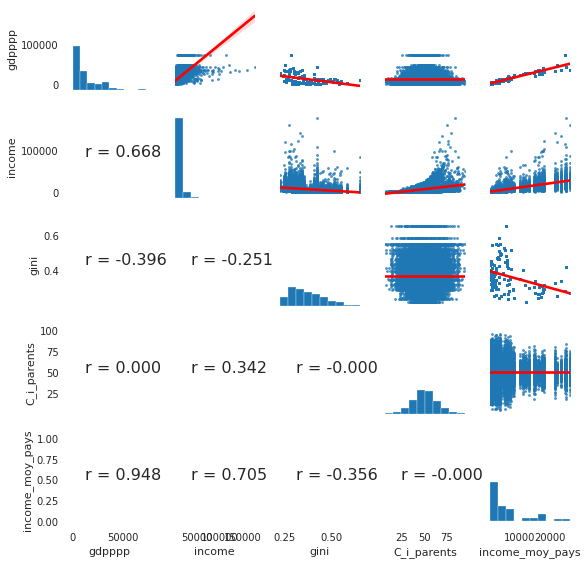

In [58]:
pairplot(data_agg[['nom_pays','gdpppp','income','gini','C_i_parents','income_moy_pays']])

In [59]:
data_agg2=data_agg[['nom_pays','gdpppp','income','gini','C_i_parents','income_moy_pays']]
prof = data_agg.profile_report()
prof.to_file(output_file='/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/analyse_data_agg.html')

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
##Controle 
len(data_agg)

11600

## Anova

In [61]:
## Anova income / pays
fit = statsmodels.formula.api.ols('income ~ nom_pays', data_agg).fit()
table = statsmodels.api.stats.anova_lm(fit)
print(fit.summary().tables[0])
print(table)

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     98.43
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:51:05   Log-Likelihood:            -1.1862e+05
No. Observations:               11600   AIC:                         2.375e+05
Df Residuals:                   11484   BIC:                         2.383e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
               df        sum_sq       mean_sq          F  PR(>F)
nom_pays    115.0  5.102375e+11  4.436848e+09  98.429273     0.0
Residual  11484.0  5.176586e+11  4.507651e+07        NaN     NaN


In [62]:
## Test de normalité
st.shapiro(fit.resid)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.5609991550445557, 0.0)

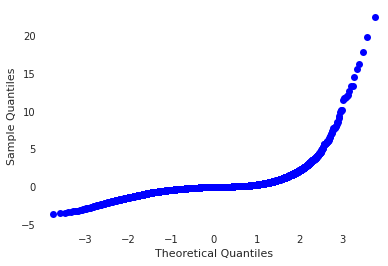

In [63]:
## QQ plots 
res = fit.resid_pearson
fig = sm.qqplot(res)
plt.show()

##  1. Regression Gini + gdpppp

In [64]:
## regression multiple
X = data_agg[['gini',"income_moy_pays"]]
X = sm.add_constant(X)
y = data_agg['income']
model = sm.OLS(y,X) ## statsmodels.formula.api.ols('income ~ gini + gdpppp', data=data_agg)
results = model.fit()
res = results.resid ## residues standard
res_pearson = results.resid_pearson ## residues standard de pearson
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     5715.
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:51:06   Log-Likelihood:            -1.1862e+05
No. Observations:               11600   AIC:                         2.372e+05
Df Residuals:                   11597   BIC:                         2.373e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.121e-10    318.395   1.

In [65]:
## Autre methode de regression
model2=statsmodels.formula.api.ols('income ~ gini + income_moy_pays', data=data_agg)
results_anov = model2.fit()
# Anova sur les variables de notre régression linéaire
anova = sm.stats.anova_lm(results_anov)
anova

df        sum_sq  ...            F         PR(>F)
gini                 1.0  6.478222e+10  ...  1451.302866  2.597858e-299
income_moy_pays      1.0  4.454553e+11  ...  9979.443569   0.000000e+00
Residual         11597.0  5.176586e+11  ...          NaN            NaN

[3 rows x 5 columns]

In [66]:
# Calcul des r2 pour chaque variables
rsqrt_gini = anova.sum_sq[anova.index[0]] / anova['sum_sq'].sum()
rsqrt_gdppp = anova.sum_sq[anova.index[1]] / anova['sum_sq'].sum()

In [67]:
## Conclusion
print('{}% de la variabilité du modele est expliqué par les variables {}'.format(round(results.rsquared *100,2),X.columns.values.tolist()))
print('La variable {} explique {}% de la variance de income '.format(anova.index[0],round(rsqrt_gini*100,2)))
print('La variable {} explique {}% de la variance de income '.format(anova.index[1],round(rsqrt_gdppp*100,2)))

49.64% de la variabilité du modele est expliqué par les variables ['const', 'gini', 'income_moy_pays']
La variable gini explique 6.3% de la variance de income 
La variable income_moy_pays explique 43.34% de la variance de income 


### **Performance du modele**

In [68]:
## Parametre 
alpha = 0.05
n = X.shape[0]
p = len(X.columns.values.tolist())

#### Calculez les leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [69]:
 ## Creation d'une colonne levier 
data_agg['levier'] = results.get_influence().hat_matrix_diag
## Calcul du seuil
seuil_levier = 2*p/n
## Creation des variables 
atyp_levier = data_agg.loc[data_agg['levier'] > seuil_levier]
atyp_levier_pays = atyp_levier.groupby(['nom_pays']).mean().reset_index()
## Affichage du nombre d'individu
print('{} individu ont des leviers supérieurs aux seuil de {}'.format(len(atyp_levier),round(seuil_levier,6)))
## Affichage du nombre de pays concerné 
print('{} pays ont des leviers supérieurs aux seuil de {}'.format(len(atyp_levier_pays),round(seuil_levier,6)))


800 individu ont des leviers supérieurs aux seuil de 0.000517
8 pays ont des leviers supérieurs aux seuil de 0.000517


In [70]:
atyp_levier_pays

nom_pays   gdpppp     pj  ...  log_income_moy  log_C_i_parents    levier
0  Afrique du Sud   9602.0  0.677  ...        8.633714         3.637394  0.001119
1          Canada  35895.0  0.269  ...       10.074902         3.637394  0.000738
2        Honduras   3628.0  0.660  ...        8.100546         3.637394  0.000631
3         Islande  36527.0  0.400  ...       10.199454         3.637394  0.000936
4      Luxembourg  73127.0  0.381  ...       10.135296         3.637394  0.000805
5         Norvège  49070.0  0.199  ...       10.020531         3.637394  0.000633
6     Royaume-Uni  34048.0  0.481  ...        9.985510         3.637394  0.000581
7      États-Unis  43261.0  0.538  ...       10.146574         3.637394  0.001098

[8 rows x 13 columns]

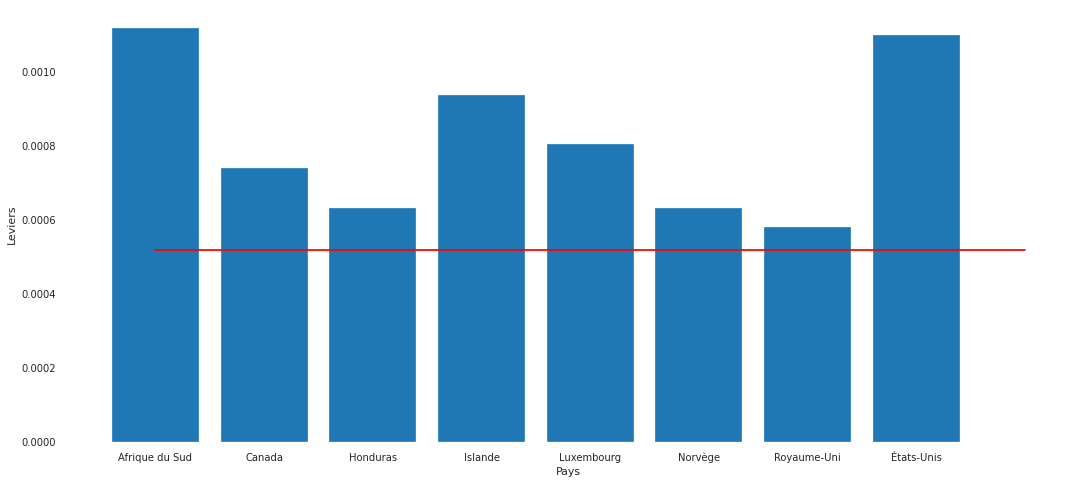

In [71]:
## Graphique
plt.figure(figsize=(18,8))
plt.bar(atyp_levier_pays['nom_pays'],atyp_levier_pays['levier'])
plt.xticks(np.arange(0, len(atyp_levier_pays), step=1))
plt.xlabel('Pays')
plt.ylabel('Leviers')
plt.plot([0, len(atyp_levier_pays)], [seuil_levier, seuil_levier], color='r')
plt.show()

#### Calculez les résidus studentisés

In [72]:
## Création d'une colonne des residus studentisés
data_agg['rstudent'] = results.get_influence().resid_studentized_internal
## Seuil = loi de student a n-p-1 degrés de liberté
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
## Création des variables
atyp_stud = data_agg.loc[np.abs(data_agg['rstudent']) > seuil_rstudent]
atyp_stud_pays = atyp_stud.groupby(['nom_pays']).mean().reset_index()
## Affichage du nombre d'individu
print('{} individu ont des leviers supérieurs aux seuil de {}'.format(len(atyp_stud),round(seuil_rstudent,6)))
## Affichage du nombre de pays concerné 
print('{} pays ont des leviers supérieurs aux seuil de {}'.format(len(atyp_stud_pays),round(seuil_rstudent,6)))

411 individu ont des leviers supérieurs aux seuil de 1.960169
68 pays ont des leviers supérieurs aux seuil de 1.960169


In [73]:
## Affichage
atyp_stud_pays

nom_pays   gdpppp     pj  ...  log_C_i_parents    levier  rstudent
0   Afrique du Sud   9602.0  0.677  ...         4.327303  0.001119  4.700350
1          Albanie   7297.0  0.816  ...         4.490591  0.000205  2.209363
2        Allemagne  33758.0  0.238  ...         3.798101  0.000371  3.082250
3        Argentine  13220.0  0.660  ...         4.393535  0.000151  3.547522
4         Autriche  36193.0  0.245  ...         3.855196  0.000336  2.984670
..             ...      ...    ...  ...              ...       ...       ...
63         Turquie  11904.0  0.400  ...         4.218873  0.000110  3.588749
64         Uruguay  11682.0  0.400  ...         4.204639  0.000163  3.750407
65       Venezuela  11756.0  0.660  ...         4.420937  0.000125  3.246790
66        Équateur   7560.0  1.030  ...         4.519305  0.000273  3.619394
67      États-Unis  43261.0  0.538  ...         3.508681  0.001098  0.428416

[68 rows x 14 columns]

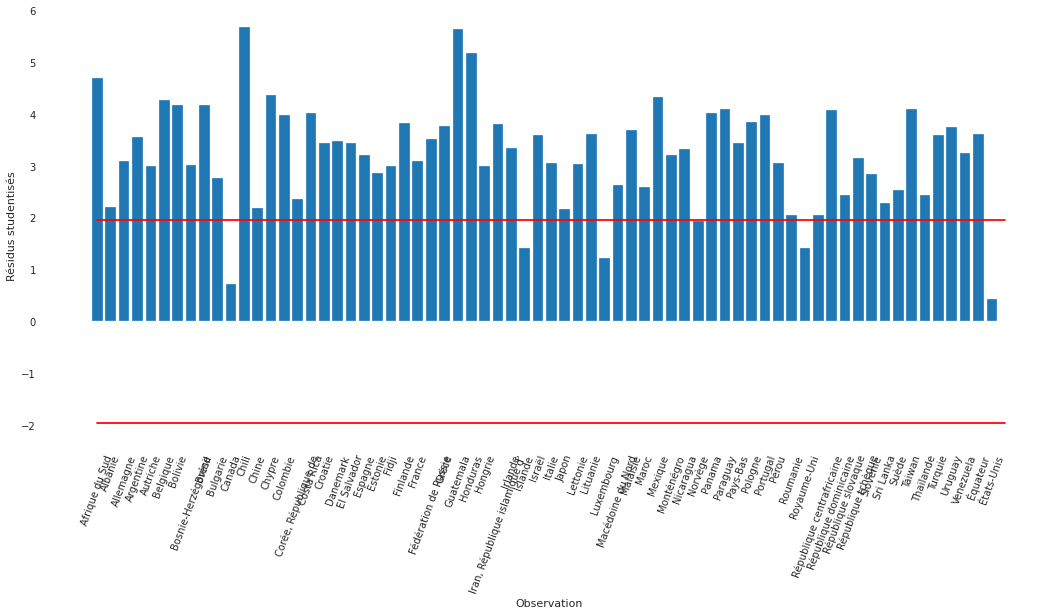

In [74]:
## Graphique 
plt.figure(figsize=(18,8))
plt.bar(atyp_stud_pays['nom_pays'], atyp_stud_pays['rstudent'])
plt.xticks(np.arange(0, len(atyp_stud_pays), step=1),rotation=70)
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, len(atyp_stud_pays)], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, len(atyp_stud_pays)], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [75]:
## Calcul des distances de cooks
influence = results.get_influence().summary_frame()
data_agg['dcooks']=influence['cooks_d']
## Seuil de cook
seuil_dcook = 4/(n-p)
## Variable contenant les pays ciblé
atyp_cook = data_agg.loc[np.abs(data_agg['dcooks']) > seuil_dcook]
atyp_cook_pays = atyp_cook.groupby(['nom_pays']).mean().reset_index()

Le seuil de la distance de Cook est de n-p. 

On peut détecter les observations influentes comme ceci :

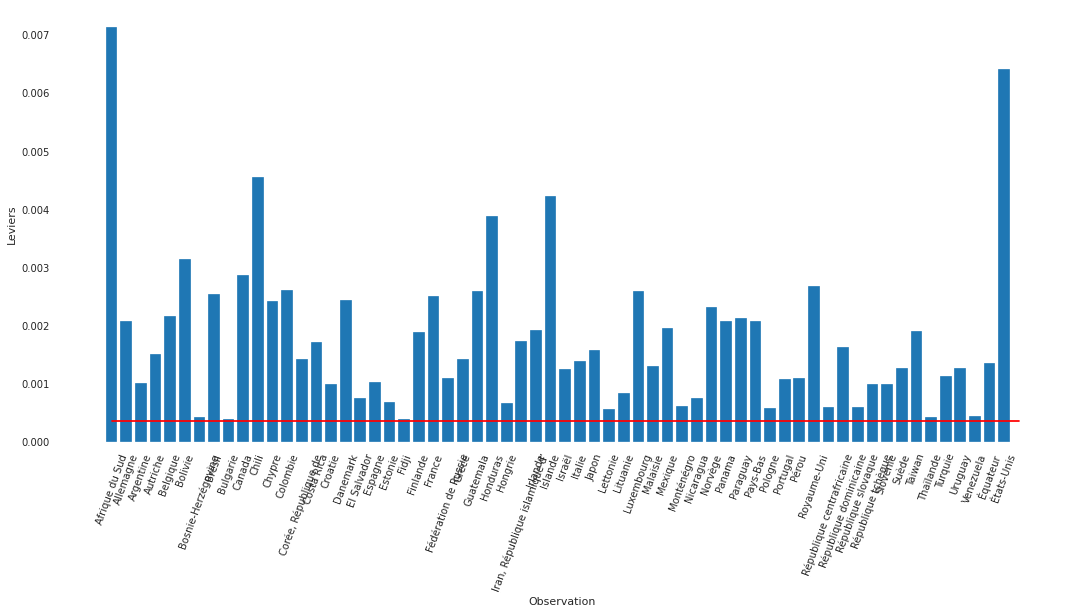

In [77]:
plt.figure(figsize=(18,8))
plt.bar(atyp_cook_pays['nom_pays'], atyp_cook_pays['dcooks'])
plt.xticks(np.arange(0, len(atyp_cook_pays), step=1),rotation = 70)
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, len(atyp_cook_pays)], [seuil_dcook, seuil_dcook], color='r')
plt.show()

#### Individus atypiques et influents

In [78]:
## Variables contnant les pays
atyp_cook = data_agg.loc[np.abs(data_agg['dcooks']) > seuil_dcook]
atyp_stud = data_agg.loc[np.abs(data_agg['rstudent']) > seuil_rstudent]
atyp_levier = data_agg.loc[data_agg['levier'] > seuil_levier]

In [79]:
## Pays atypique et influents
data_atyp = data_agg.loc[(np.abs(data_agg['dcooks']) > seuil_dcook) & (np.abs(data_agg['rstudent']) > seuil_rstudent) & (data_agg['levier'] > seuil_levier)]

In [80]:
data_atyp_agg = data_atyp.groupby(['nom_pays']).mean().reset_index()

In [81]:
data_atyp_agg

nom_pays   gdpppp     pj  ...    levier  rstudent    dcooks
0  Afrique du Sud   9602.0  0.677  ...  0.001119  4.700350  0.011733
1          Canada  35895.0  0.269  ...  0.000738  0.723349  0.004656
2        Honduras   3628.0  0.660  ...  0.000631  5.183234  0.007245
3         Islande  36527.0  0.400  ...  0.000936  1.410988  0.008771
4      Luxembourg  73127.0  0.381  ...  0.000805  1.214895  0.004867
5         Norvège  49070.0  0.199  ...  0.000633  1.933042  0.004858
6     Royaume-Uni  34048.0  0.481  ...  0.000581  1.412810  0.004640
7      États-Unis  43261.0  0.538  ...  0.001098  0.428416  0.009750

[8 rows x 15 columns]

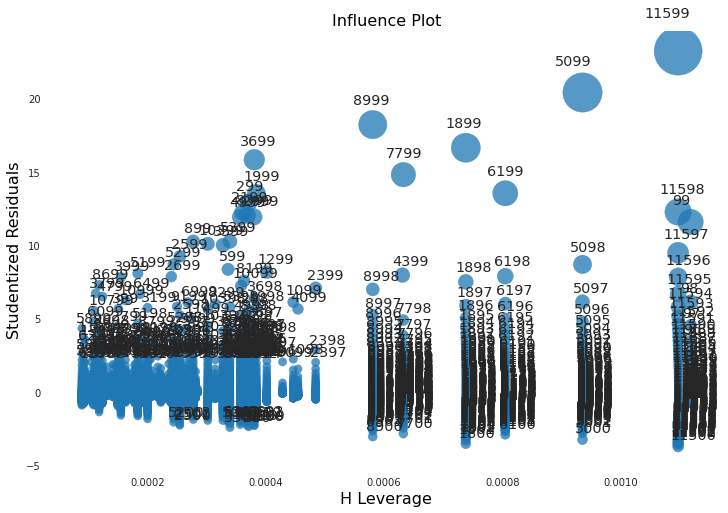

In [82]:
## Influence plot
from statsmodels.graphics.regressionplots import *
fig, ax = plt.subplots(figsize=(12,8))
fig =influence_plot(results, ax=ax)
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/reg_influenceplot.png')

In [83]:
data_agg.shape 

(11600, 15)

In [84]:
pays = list(data_atyp_agg['nom_pays'])
data_perf = data_agg[~data_agg.nom_pays.isin(pays)]
data_perf.shape 

(10800, 15)

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.


### Conditions de validité du modele

#### Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [85]:
variables = results.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1454292371708414, 1.1454292371708399]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [86]:
#matrice des corrélations avec scipy
mc = np.corrcoef(X,rowvar = 0)
print(mc)

[[        nan         nan         nan]
 [        nan  1.         -0.35632126]
 [        nan -0.35632126  1.        ]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [87]:
#règle de Klein
mc2 = mc**2
print(mc2)

[[       nan        nan        nan]
 [       nan 1.         0.12696484]
 [       nan 0.12696484 1.        ]]


In [88]:
#critère VIF
vif = np.linalg.inv(mc)
print(vif)

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]


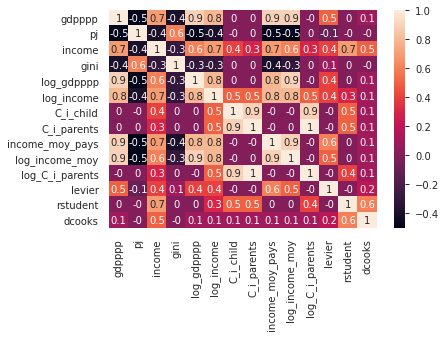

In [89]:
#etude de la correlation
matrice_corr = data_agg.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)


#### Testez l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [90]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(results.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 5.70222682228646e-74


La p-valeur ici est inférieure à  5 %, on  rejette  l'hypothèse  H0  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

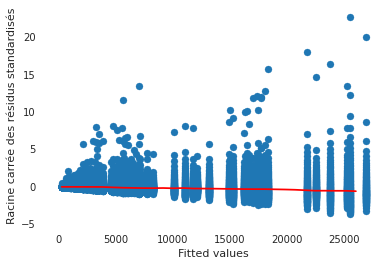

In [91]:
##sqrt_residues_std = np.sqrt(abs(residues_std)) # ne fonctionne pas si on ne met pas abs
sqrt_residues_std = results.get_influence().resid_studentized_internal
fitted_values =  results.predict(X)
from matplotlib.pyplot import plot, scatter, show, xlabel, ylabel
scatter(fitted_values,sqrt_residues_std)
xlabel("Fitted values")
ylabel("Racine carrée des résidus standardisés")
# en reprenant la fonction smooth() plus haut
xs , ys = smooth(fitted_values,sqrt_residues_std,box_percent=0.25,res=30)
plot(xs,ys,"-r")
show()

####1) Les individus sont indépendantes


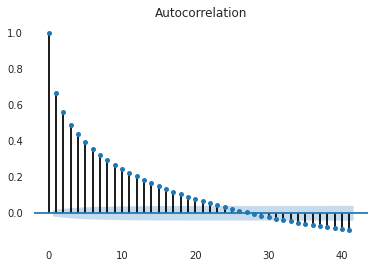

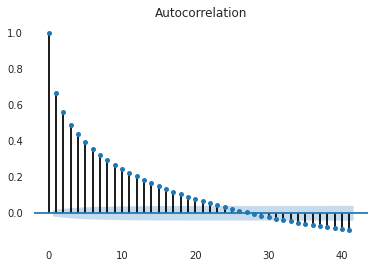

In [92]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(res)

#### 2) Les résidus suivent une distribution normale ( Shapiro )

In [93]:
## Test de shapiro
st.shapiro(res_pearson)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.5609992742538452, 0.0)

In [94]:
## Test de kolmogorov
ks_2samp(results.resid,list(np.random.normal(np.mean(res), np.std(res), len(data_agg))))

Ks_2sampResult(statistic=0.24275862068965515, pvalue=2.592555160174726e-297)

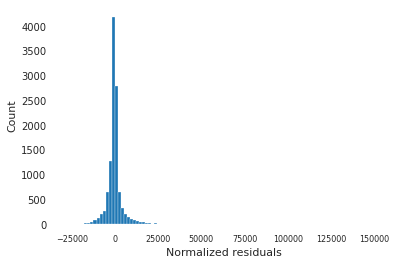

In [95]:
##Visualisation
plt.hist(res,100)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.xticks(fontsize=8)
plt.show()

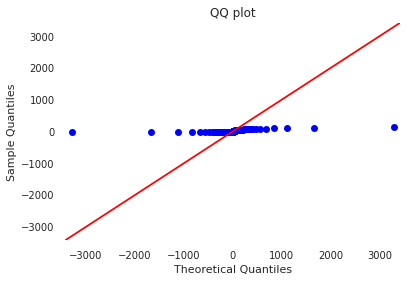

In [96]:
## QQ plot
residues_std = results.get_influence().resid_studentized_internal
fig = sm.qqplot(residues_std, st.t, fit=True,line='45')
plt.title("QQ plot")
plt.show()

##  2. Regression Gini + gdpppp LOG

In [97]:
## regression multiple
X = data_agg[['gini',"log_income_moy"]]
X = sm.add_constant(X)
y = data_agg['log_income']
model = sm.OLS(y,X) ## statsmodels.formula.api.ols('income ~ gini + gdpppp', data=data_agg)
results = model.fit()
res = results.resid ## residues standard
res_pearson = results.resid_pearson ## residues standard de pearson
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 1.558e+04
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:52:53   Log-Likelihood:                -12637.
No. Observations:               11600   AIC:                         2.528e+04
Df Residuals:                   11597   BIC:                         2.530e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4712      0.064      7.

In [98]:
## Autre methode de regression
model2=statsmodels.formula.api.ols('log_income ~ gini + log_income_moy', data=data_agg)
results_anov = model2.fit()
# Anova sur les variables de notre régression linéaire
anova = sm.stats.anova_lm(results_anov)
anova

df        sum_sq       mean_sq             F  PR(>F)
gini                1.0   2331.765417   2331.765417   4506.422105     0.0
log_income_moy      1.0  13792.617670  13792.617670  26655.922038     0.0
Residual        11597.0   6000.654822      0.517432           NaN     NaN

In [99]:
# Calcul des r2 pour chaque variables
rsqrt_gini = anova.sum_sq[anova.index[0]] / anova['sum_sq'].sum()
rsqrt_gdppp = anova.sum_sq[anova.index[1]] / anova['sum_sq'].sum()

In [100]:
## Conclusion
print('{}% de la variabilité du modele est expliqué par les variables {}'.format(round(results.rsquared *100,2),X.columns.values.tolist()))
print('La variable {} explique {}% de la variance de income '.format(anova.index[0],round(rsqrt_gini*100,2)))
print('La variable {} explique {}% de la variance de income '.format(anova.index[1],round(rsqrt_gdppp*100,2)))

72.88% de la variabilité du modele est expliqué par les variables ['const', 'gini', 'log_income_moy']
La variable gini explique 10.54% de la variance de income 
La variable log_income_moy explique 62.34% de la variance de income 


### **Performance du modele**

In [101]:
## Parametre 
alpha = 0.05
n = X.shape[0]
p = len(X.columns.values.tolist())

#### Calculez les leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [102]:
 ## Creation d'une colonne levier 
data_agg['levier'] = results.get_influence().hat_matrix_diag
## Calcul du seuil
seuil_levier = 2*p/n
## Creation des variables 
atyp_levier = data_agg.loc[data_agg['levier'] > seuil_levier]
atyp_levier_pays = atyp_levier.groupby(['nom_pays']).mean().reset_index()
## Affichage du nombre d'individu
print('{} individu ont des leviers supérieurs aux seuil de {}'.format(len(atyp_levier),round(seuil_levier,6)))
## Affichage du nombre de pays concerné 
print('{} pays ont des leviers supérieurs aux seuil de {}'.format(len(atyp_levier_pays),round(seuil_levier,6)))


200 individu ont des leviers supérieurs aux seuil de 0.000517
2 pays ont des leviers supérieurs aux seuil de 0.000517


In [103]:
atyp_levier_pays

nom_pays  gdpppp     pj  ...    levier      rstudent    dcooks
0  Afrique du Sud  9602.0  0.677  ...  0.001165  4.563461e-14  0.000968
1        Honduras  3628.0  0.660  ...  0.000650  8.176571e-14  0.000183

[2 rows x 15 columns]

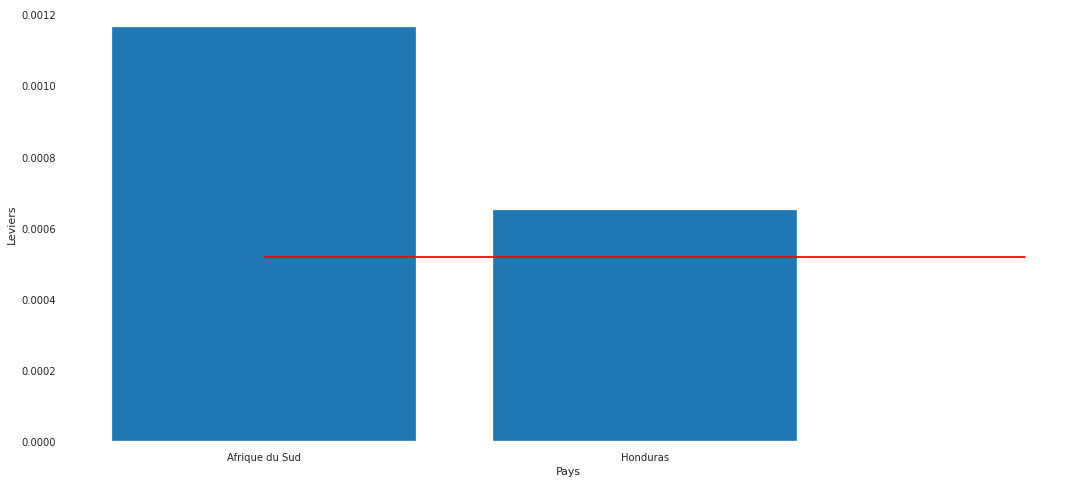

In [104]:
## Graphique
plt.figure(figsize=(18,8))
plt.bar(atyp_levier_pays['nom_pays'],atyp_levier_pays['levier'])
plt.xticks(np.arange(0, len(atyp_levier_pays), step=1))
plt.xlabel('Pays')
plt.ylabel('Leviers')
plt.plot([0, len(atyp_levier_pays)], [seuil_levier, seuil_levier], color='r')
plt.show()

#### Calculez les résidus studentisés

In [105]:
## Création d'une colonne des residus studentisés
data_agg['rstudent'] = results.get_influence().resid_studentized_internal
## Seuil = loi de student a n-p-1 degrés de liberté
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
## Création des variables
atyp_stud = data_agg.loc[np.abs(data_agg['rstudent']) > seuil_rstudent]
atyp_stud_pays = atyp_stud.groupby(['nom_pays']).mean().reset_index()
## Affichage du nombre d'individu
print('{} individu ont des leviers supérieurs aux seuil de {}'.format(len(atyp_stud),round(seuil_rstudent,6)))
## Affichage du nombre de pays concerné 
print('{} pays ont des leviers supérieurs aux seuil de {}'.format(len(atyp_stud_pays),round(seuil_rstudent,6)))

638 individu ont des leviers supérieurs aux seuil de 1.960169
114 pays ont des leviers supérieurs aux seuil de 1.960169


In [106]:
## Affichage
atyp_stud_pays

nom_pays   gdpppp     pj  ...    levier  rstudent    dcooks
0                 Afrique du Sud   9602.0  0.677  ...  0.001165 -0.264588  0.003084
1                        Albanie   7297.0  0.816  ...  0.000157  2.672442  0.000334
2                      Allemagne  33758.0  0.238  ...  0.000291 -0.010597  0.010510
3                      Argentine  13220.0  0.660  ...  0.000191 -0.322780  0.000248
4                        Arménie   5611.0  0.400  ...  0.000319  0.026263  0.000035
..                           ...      ...    ...  ...       ...       ...       ...
109                     Viet Nam   2578.0  0.480  ...  0.000141  1.052811  0.000028
110               Yémen, Rép. du   2224.0  0.660  ...  0.000185  1.114739  0.000027
111  Égypte, République arabe d’   5011.0  0.943  ...  0.000148  2.561990  0.000130
112                     Équateur   7560.0  1.030  ...  0.000287  0.110634  0.000270
113                   États-Unis  43261.0  0.538  ...  0.000468 -0.700253  0.032345

[114 rows x 15 columns]

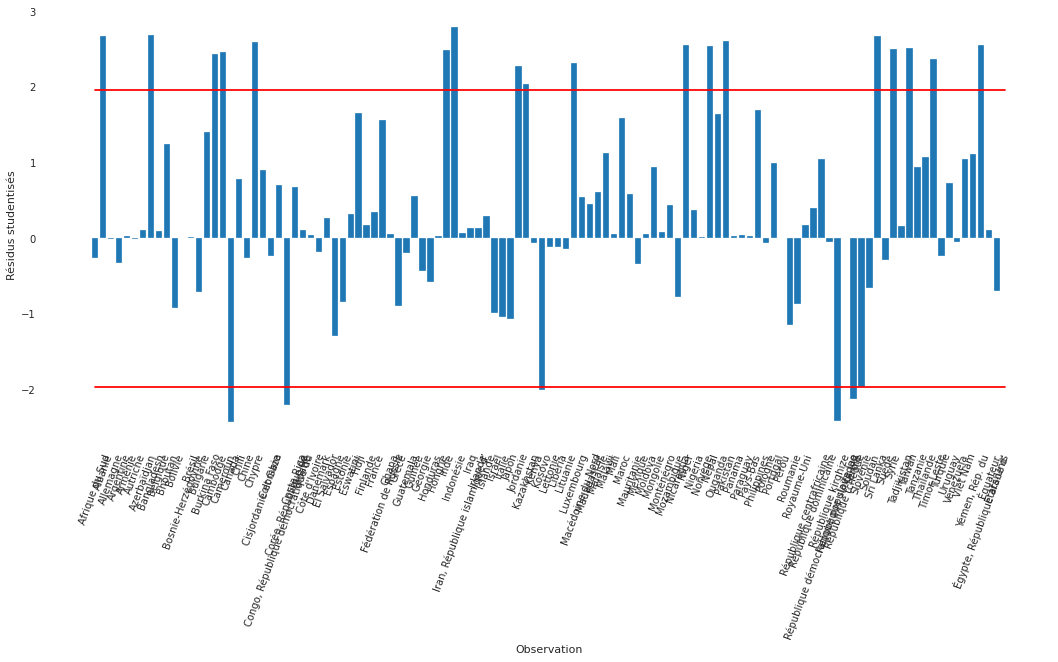

In [107]:
## Graphique 
plt.figure(figsize=(18,8))
plt.bar(atyp_stud_pays['nom_pays'], atyp_stud_pays['rstudent'])
plt.xticks(np.arange(0, len(atyp_stud_pays), step=1),rotation=70)
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, len(atyp_stud_pays)], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, len(atyp_stud_pays)], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [108]:
## Calcul des distances de cooks
influence = results.get_influence().summary_frame()
data_agg['dcooks']=influence['cooks_d']
## Seuil de cook
seuil_dcook = 4/(n-p)
## Variable contenant les pays ciblé
atyp_cook = data_agg.loc[np.abs(data_agg['dcooks']) > seuil_dcook]
atyp_cook_pays = atyp_cook.groupby(['nom_pays']).mean().reset_index()

Le seuil de la distance de Cook est de n-p. 

On peut détecter les observations influentes comme ceci :

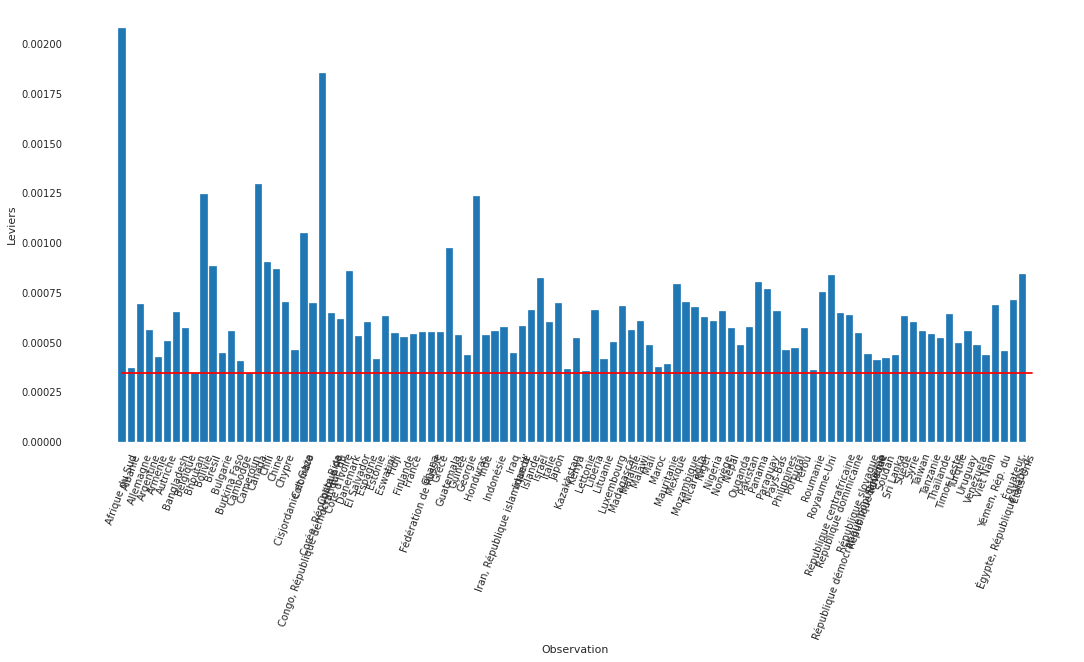

In [110]:
plt.figure(figsize=(18,8))
plt.bar(atyp_cook_pays['nom_pays'], atyp_cook_pays['dcooks'])
plt.xticks(np.arange(0, len(atyp_cook_pays), step=1),rotation = 70)
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, len(atyp_cook_pays)], [seuil_dcook, seuil_dcook], color='r')
plt.show()

#### Individus atypiques et influents

In [111]:
## Variables contnant les pays
atyp_cook = data_agg.loc[np.abs(data_agg['dcooks']) > seuil_dcook]
atyp_stud = data_agg.loc[np.abs(data_agg['rstudent']) > seuil_rstudent]
atyp_levier = data_agg.loc[data_agg['levier'] > seuil_levier]

In [112]:
## Pays atypique et influents
data_atyp = data_agg.loc[(np.abs(data_agg['dcooks']) > seuil_dcook) & (np.abs(data_agg['rstudent']) > seuil_rstudent) & (data_agg['levier'] > seuil_levier)]

In [113]:
data_atyp_agg = data_atyp.groupby(['nom_pays']).mean().reset_index()

In [114]:
data_atyp_agg

nom_pays  gdpppp     pj  ...    levier  rstudent    dcooks
0  Afrique du Sud  9602.0  0.677  ...  0.001165 -0.264588  0.003530
1        Honduras  3628.0  0.660  ...  0.000650 -0.572185  0.001915

[2 rows x 15 columns]

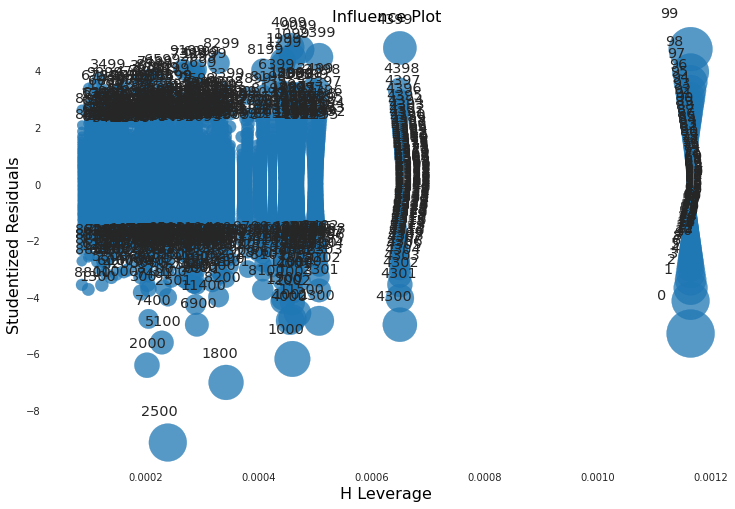

In [115]:
## Influence plot
from statsmodels.graphics.regressionplots import *
fig, ax = plt.subplots(figsize=(12,8))
fig =influence_plot(results, ax=ax)
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/reg_influenceplot.png')

In [116]:
data_agg.shape 

(11600, 15)

In [117]:
pays = list(data_atyp_agg['nom_pays'])
data_perf = data_agg[~data_agg.nom_pays.isin(pays)]
data_perf.shape 

(11400, 15)

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.


### Conditions de validité du modele

#### Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [118]:
variables = results.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.076834541640814, 1.0768345416408134]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [119]:
#matrice des corrélations avec scipy
mc = np.corrcoef(X,rowvar = 0)
print(mc)

[[        nan         nan         nan]
 [        nan  1.         -0.26711837]
 [        nan -0.26711837  1.        ]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [120]:
#règle de Klein
mc2 = mc**2
print(mc2)

[[       nan        nan        nan]
 [       nan 1.         0.07135223]
 [       nan 0.07135223 1.        ]]


In [121]:
#critère VIF
vif = np.linalg.inv(mc)
print(vif)

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]


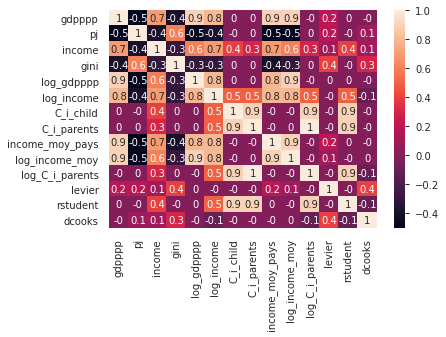

In [122]:
#etude de la correlation
matrice_corr = data_agg.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)


#### Testez l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [123]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(results.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.517429948828702e-154


La p-valeur ici est inférieure à  5 %, on  rejette  l'hypothèse  H0  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

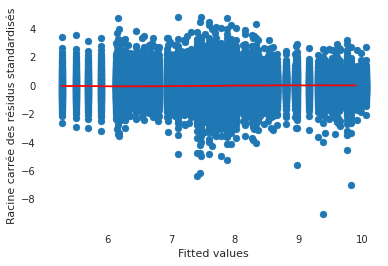

In [124]:
##sqrt_residues_std = np.sqrt(abs(residues_std)) # ne fonctionne pas si on ne met pas abs
sqrt_residues_std = results.get_influence().resid_studentized_internal
fitted_values =  results.predict(X)
from matplotlib.pyplot import plot, scatter, show, xlabel, ylabel
scatter(fitted_values,sqrt_residues_std)
xlabel("Fitted values")
ylabel("Racine carrée des résidus standardisés")
# en reprenant la fonction smooth() plus haut
xs , ys = smooth(fitted_values,sqrt_residues_std,box_percent=0.25,res=30)
plot(xs,ys,"-r")
show()

####1) Les individus sont indépendantes


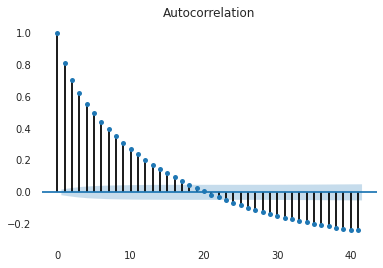

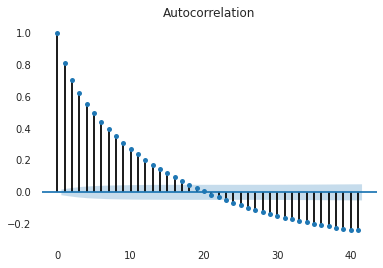

In [125]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(res)

#### 2) Les résidus suivent une distribution normale ( Shapiro )

In [126]:
## Test de shapiro
st.shapiro(res_pearson)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9782117009162903, 1.3641497617758733e-38)

In [127]:
## Test de kolmogorov
ks_2samp(results.resid,list(np.random.normal(np.mean(res), np.std(res), len(data_agg))))

Ks_2sampResult(statistic=0.03491379310344822, pvalue=1.4456680479188321e-06)

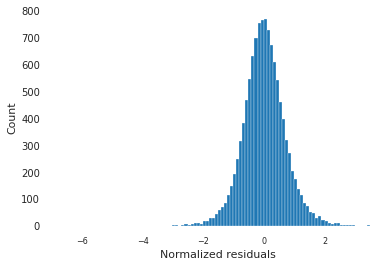

In [128]:
##Visualisation
plt.hist(res,100)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.xticks(fontsize=8)
plt.show()

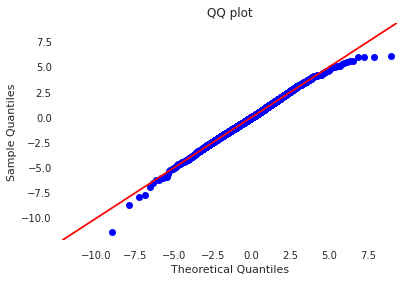

In [129]:
## QQ plot
residues_std = results.get_influence().resid_studentized_internal
fig = sm.qqplot(residues_std, st.t, fit=True,line='45')
plt.title("QQ plot")
plt.show()

##  3. Regression Gini + gdpppp + C_i_parents

In [130]:
## regression multiple
X = data_agg[['gini',"income_moy_pays",'C_i_parents']]
X = sm.add_constant(X)
y = data_agg['income']
model = sm.OLS(y,X) ## statsmodels.formula.api.ols('income ~ gini + gdpppp', data=data_agg)
results = model.fit()
res = results.resid ## residues standard
res_pearson = results.resid_pearson ## residues standard de pearson
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     6140.
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:54:46   Log-Likelihood:            -1.1708e+05
No. Observations:               11600   AIC:                         2.342e+05
Df Residuals:                   11596   BIC:                         2.342e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.231e+04    347.630    -

In [131]:
## Autre methode de regression
model2=statsmodels.formula.api.ols('income ~ gini + income_moy_pays + C_i_parents', data=data_agg)
results_anov = model2.fit()
# Anova sur les variables de notre régression linéaire
anova = sm.stats.anova_lm(results_anov)
anova

df        sum_sq       mean_sq             F  PR(>F)
gini                 1.0  6.478222e+10  6.478222e+10   1891.643682     0.0
income_moy_pays      1.0  4.454553e+11  4.454553e+11  13007.313516     0.0
C_i_parents          1.0  1.205359e+11  1.205359e+11   3519.653874     0.0
Residual         11596.0  3.971227e+11  3.424653e+07           NaN     NaN

In [132]:
# Calcul des r2 pour chaque variables
rsqrt_gini = anova.sum_sq[anova.index[0]] / anova['sum_sq'].sum()
rsqrt_gdppp = anova.sum_sq[anova.index[1]] / anova['sum_sq'].sum()
rsqrt_C_i_parents = anova.sum_sq[anova.index[2]] / anova['sum_sq'].sum()

In [133]:
## Conclusion
print('{}% de la variabilité du modele est expliqué par les variables {}'.format(round(results.rsquared *100,2),X.columns.values.tolist()))
print('La variable {} explique {}% de la variance de income '.format(anova.index[0],round(rsqrt_gini*100,2)))
print('La variable {} explique {}% de la variance de income '.format(anova.index[1],round(rsqrt_gdppp*100,2)))
print('La variable {} explique {}% de la variance de income '.format(anova.index[2],round(rsqrt_C_i_parents*100,2)))

61.37% de la variabilité du modele est expliqué par les variables ['const', 'gini', 'income_moy_pays', 'C_i_parents']
La variable gini explique 6.3% de la variance de income 
La variable income_moy_pays explique 43.34% de la variance de income 
La variable C_i_parents explique 11.73% de la variance de income 


### **Performance du modele**

In [134]:
## Parametre 
alpha = 0.05
n = X.shape[0]
p = len(X.columns.values.tolist())

#### Calculez les leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [135]:
 ## Creation d'une colonne levier 
data_agg['levier'] = results.get_influence().hat_matrix_diag
## Calcul du seuil
seuil_levier = 2*p/n
## Creation des variables 
atyp_levier = data_agg.loc[data_agg['levier'] > seuil_levier]
atyp_levier_pays = atyp_levier.groupby(['nom_pays']).mean().reset_index()
## Affichage du nombre d'individu
print('{} individu ont des leviers supérieurs aux seuil de {}'.format(len(atyp_levier),round(seuil_levier,6)))
## Affichage du nombre de pays concerné 
print('{} pays ont des leviers supérieurs aux seuil de {}'.format(len(atyp_levier_pays),round(seuil_levier,6)))


919 individu ont des leviers supérieurs aux seuil de 0.00069
60 pays ont des leviers supérieurs aux seuil de 0.00069


In [136]:
atyp_levier_pays

nom_pays    gdpppp  ...  rstudent    dcooks
0                      Afrique du Sud   9602.00  ... -0.230756  0.001333
1                             Albanie   7297.00  ...  0.197949  0.000149
2                           Argentine  13220.00  ... -0.234183  0.000819
3                             Arménie   5611.00  ...  0.026263  0.000429
4                          Bangladesh   1233.00  ...  0.553619  0.000439
5                             Bolivie   3950.00  ... -0.405795  0.001241
6                  Bosnie-Herzégovine   7472.00  ... -0.345692  0.000186
7                              Brésil   9559.00  ...  0.017620  0.001469
8                        Burkina Faso   1085.51  ...  0.549948  0.000528
9                            Cameroun   2007.00  ...  0.669961  0.000227
10                             Canada  35895.00  ... -0.016682  0.000162
11                              Chili  13390.00  ...  0.261560  0.001437
12                Cisjordanie et Gaza   4965.37  ...  0.296481  0.000374
13                           Colombie   8185.00  ... -0.079662  0.000910
14  Congo, République démocratique du    303.19  ...  0.295579  0.001237
15                         Costa Rica  10374.00  ...  0.651434  0.000948
16                      Côte d'Ivoire   1526.00  ...  0.070259  0.001187
17                        El Salvador   6270.00  ...  0.141982  0.000612
18                           Eswatini   4748.00  ...  0.960523  0.001076
19                             France  30357.00  ...  2.933725  0.000803
20                          Guatemala   4367.00  ... -0.133489  0.000826
21                           Honduras   3628.00  ... -0.150725  0.001067
22                               Inde   2796.00  ...  0.649217  0.000459
23      Iran, République islamique d’  10446.00  ...  0.196772  0.000576
24                               Iraq   3171.00  ...  0.226432  0.000388
25                            Islande  36527.00  ...  0.001208  0.000064
26                             Italie  28170.00  ... -0.448756  0.000708
27                              Kenya   1429.00  ...  0.089420  0.000477
28                           Lettonie  15596.00  ...  0.293309  0.000234
29                            Libéria    372.00  ... -0.245878  0.001035
30                         Luxembourg  73127.00  ...  0.016357  0.000066
31                         Madagascar    950.00  ...  0.210606  0.001168
32                           Malaisie  13163.00  ...  0.454091  0.000759
33                             Malawi    728.81  ...  0.569785  0.000577
34                               Mali    929.53  ... -0.210859  0.000394
35                              Maroc   3973.00  ...  0.380858  0.000165
36                         Mauritanie   2226.73  ...  0.248291  0.000336
37                            Mexique  13434.00  ... -0.310390  0.001276
38                         Mozambique    773.00  ... -0.620187  0.001000
39                          Nicaragua   2576.00  ...  0.132487  0.000879
40                              Niger    631.00  ...  0.674841  0.000632
41                            Nigéria   1946.00  ...  1.125617  0.000975
42                            Norvège  49070.00  ... -0.588759  0.000412
43                            Ouganda   1067.00  ...  0.169441  0.000329
44                           Pakistan   2335.00  ...  0.571590  0.000501
45                             Panama  11767.00  ...  0.022546  0.000845
46                           Paraguay   4347.00  ... -0.291696  0.001141
47                              Pérou   7858.00  ... -0.861278  0.000757
48                        Royaume-Uni  34048.00  ...  0.100865  0.000276
49          République centrafricaine    685.00  ...  0.303559  0.001132
50             République dominicaine   7505.00  ... -0.163261  0.000832
51                République slovaque  20515.00  ... -0.407578  0.000395
52                             Soudan   2345.00  ... -0.000761  0.000424
53                              Syrie   4512.00  ... -0.206130  0.000444
54            

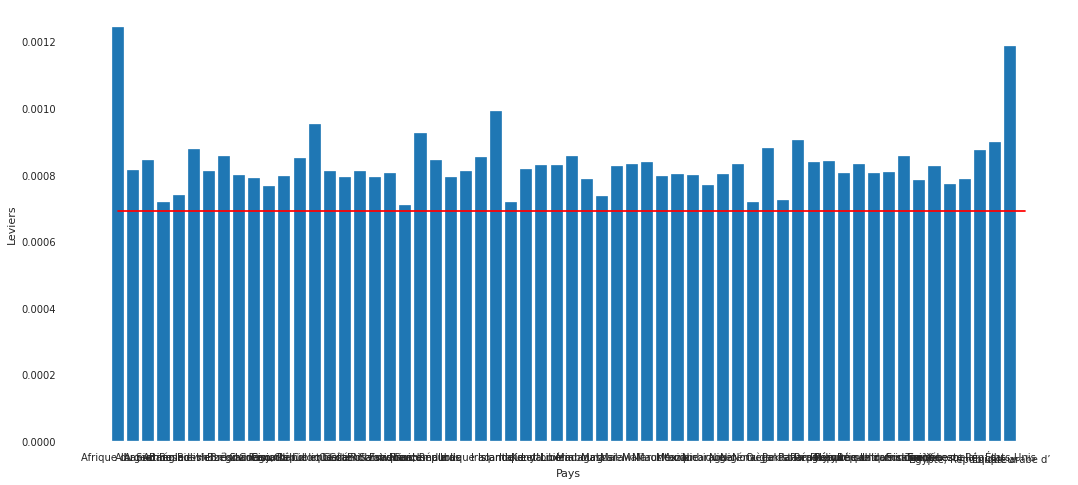

In [137]:
## Graphique
plt.figure(figsize=(18,8))
plt.bar(atyp_levier_pays['nom_pays'],atyp_levier_pays['levier'])
plt.xticks(np.arange(0, len(atyp_levier_pays), step=1))
plt.xlabel('Pays')
plt.ylabel('Leviers')
plt.plot([0, len(atyp_levier_pays)], [seuil_levier, seuil_levier], color='r')
plt.show()

#### Calculez les résidus studentisés

In [138]:
## Création d'une colonne des residus studentisés
data_agg['rstudent'] = results.get_influence().resid_studentized_internal
## Seuil = loi de student a n-p-1 degrés de liberté
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
## Création des variables
atyp_stud = data_agg.loc[np.abs(data_agg['rstudent']) > seuil_rstudent]
atyp_stud_pays = atyp_stud.groupby(['nom_pays']).mean().reset_index()
## Affichage du nombre d'individu
print('{} individu ont des leviers supérieurs aux seuil de {}'.format(len(atyp_stud),round(seuil_rstudent,6)))
## Affichage du nombre de pays concerné 
print('{} pays ont des leviers supérieurs aux seuil de {}'.format(len(atyp_stud_pays),round(seuil_rstudent,6)))

303 individu ont des leviers supérieurs aux seuil de 1.960169
60 pays ont des leviers supérieurs aux seuil de 1.960169


In [139]:
## Affichage
atyp_stud_pays

nom_pays    gdpppp  ...  rstudent    dcooks
0                  Afrique du Sud   9602.00  ...  5.197134  0.005624
1                       Allemagne  33758.00  ...  3.942324  0.000294
2                       Argentine  13220.00  ...  4.901601  0.000712
3                        Autriche  36193.00  ...  3.720565  0.000211
4                        Belgique  33561.00  ...  4.458036  0.000252
5                         Bolivie   3950.00  ...  5.239345  0.003103
6              Bosnie-Herzégovine   7472.00  ...  2.546111  0.000248
7                          Brésil   9559.00  ...  5.344688  0.002121
8                        Bulgarie  11993.00  ...  2.939223  0.000250
9                          Canada  35895.00  ...  1.001091  0.000489
10                          Chili  13390.00  ...  6.223879  0.001661
11                         Chypre  26273.00  ...  4.657727  0.000266
12                       Colombie   8185.00  ...  6.176993  0.003421
13           Corée, République de  19162.00  ...  4.142803  0.000259
14                     Costa Rica  10374.00  ...  5.095158  0.001132
15                        Croatie  17219.00  ...  3.866597  0.000336
16                       Danemark  34130.00  ...  3.528493  0.000349
17                    El Salvador   6270.00  ...  2.397914  0.000848
18                        Espagne  28336.00  ...  3.257200  0.000225
19                        Estonie  18773.00  ...  3.075317  0.000282
20                          Fidji  10771.44  ...  2.327697  0.000547
21                       Finlande  33626.00  ...  4.095885  0.000220
22                         France  30357.00  ...  5.178435  0.000277
23           Fédération de Russie  14766.00  ...  3.661164  0.000351
24                          Grèce  27123.00  ...  4.024652  0.000251
25                      Guatemala   4367.00  ...  4.632829  0.003563
26                       Honduras   3628.00  ...  7.536134  0.005030
27                        Hongrie  18004.00  ...  2.284470  0.000327
28  Iran, République islamique d’  10446.00  ...  5.841918  0.000645
29                        Irlande  39268.00  ...  4.295790  0.000227
30                        Islande  36527.00  ...  2.860813  0.000268
31                         Israël  25740.00  ...  3.822096  0.000362
32                         Italie  28170.00  ...  4.004674  0.000252
33                          Japon  31307.00  ...  4.266116  0.000238
34                       Lettonie  15596.00  ...  3.189642  0.000282
35                       Lituanie  17571.00  ...  4.373881  0.000321
36                     Luxembourg  73127.00  ...  2.198875  0.000239
37              Macédoine du Nord   8809.00  ...  2.517232  0.000269
38                       Malaisie  13163.00  ...  4.494304  0.000786
39                        Mexique  13434.00  ...  5.405902  0.001592
40                     Monténégro  10556.00  ...  2.537690  0.000291
41                      Nicaragua   2576.00  ...  2.270133  0.000973
42                        Norvège  49070.00  ...  2.798267  0.000282
43                         Panama  11767.00  ...  4.704058  0.001796
44                       Paraguay   4347.00  ...  5.333914  0.002015
45                       Pays-Bas  38065.00  ...  4.476873  0.000245
46                        Pologne  16436.00  ...  3.269755  0.000283
47                       Portugal  21956.00  ...  3.863609  0.000252
48                          Pérou   7858.00  ...  3.111954  0.000921
49                    Royaume-Uni  34048.00  ...  4.340230  0.000353
50         République dominicaine   7505.00  ...  5.022602  0.001483
51             République tchèque  23223.00  ...  3.704785  0.000443
52                       Slovénie  27197.00  ...  2.962227  0.000271
53                          Suède  34371.00  ...  3.482754  0.000219
54                         Taiwan  25342.00  ...  4.318609  0.000227
55                        Turquie  11904.00  ...  3.778682  0.000406
56                        Uruguay  11682.00  ...  4.206304  0.000666
57                     

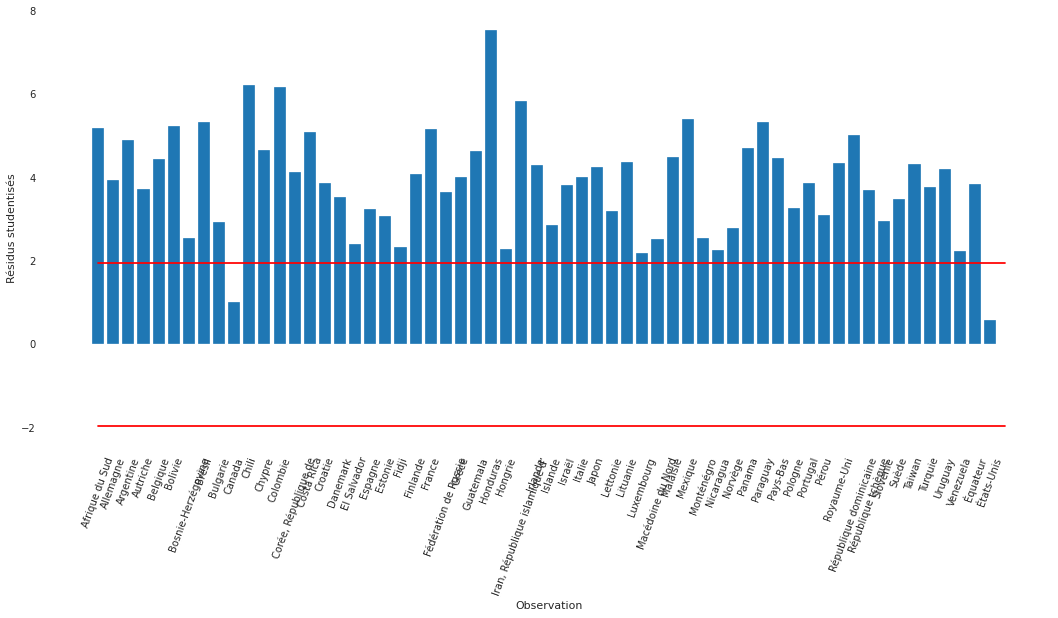

In [140]:
## Graphique 
plt.figure(figsize=(18,8))
plt.bar(atyp_stud_pays['nom_pays'], atyp_stud_pays['rstudent'])
plt.xticks(np.arange(0, len(atyp_stud_pays), step=1),rotation=70)
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, len(atyp_stud_pays)], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, len(atyp_stud_pays)], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [ ]:
## Calcul des distances de cooks
influence = results.get_influence().summary_frame()
data_agg['dcooks']=influence['cooks_d']
## Seuil de cook
seuil_dcook = 4/(n-p)
## Variable contenant les pays ciblé
atyp_cook = data_agg.loc[np.abs(data_agg['dcooks']) > seuil_dcook]
atyp_cook_pays = atyp_cook.groupby(['nom_pays']).mean().reset_index()

#### Individus atypiques et influents

In [141]:
## Variables contnant les pays
atyp_cook = data_agg.loc[np.abs(data_agg['dcooks']) > seuil_dcook]
atyp_stud = data_agg.loc[np.abs(data_agg['rstudent']) > seuil_rstudent]
atyp_levier = data_agg.loc[data_agg['levier'] > seuil_levier]

In [142]:
## Pays atypique et influents
data_atyp = data_agg.loc[(np.abs(data_agg['dcooks']) > seuil_dcook) & (np.abs(data_agg['rstudent']) > seuil_rstudent) & (data_agg['levier'] > seuil_levier)]

In [143]:
data_atyp_agg = data_atyp.groupby(['nom_pays']).mean().reset_index()

In [144]:
data_atyp_agg

nom_pays   gdpppp  ...   rstudent    dcooks
0                  Afrique du Sud   9602.0  ...   5.197134  0.005624
1                       Argentine  13220.0  ...   4.901601  0.000712
2                         Bolivie   3950.0  ...   5.239345  0.003103
3                          Brésil   9559.0  ...   5.344688  0.002121
4                          Canada  35895.0  ...   1.026554  0.001297
5                           Chili  13390.0  ...   6.223879  0.001661
6                        Colombie   8185.0  ...   6.176993  0.003421
7                      Costa Rica  10374.0  ...   5.095158  0.001132
8                     El Salvador   6270.0  ...   2.397914  0.000848
9                          France  30357.0  ...  16.782293  0.000803
10                      Guatemala   4367.0  ...   4.632829  0.003563
11                       Honduras   3628.0  ...   7.536134  0.005030
12  Iran, République islamique d’  10446.0  ...   5.841918  0.000645
13                        Islande  36527.0  ...   9.399544  0.000664
14                         Italie  28170.0  ...   8.613020  0.000495
15                     Luxembourg  73127.0  ...   6.649614  0.000501
16                       Malaisie  13163.0  ...   6.203975  0.000977
17                        Mexique  13434.0  ...   5.405902  0.001592
18                      Nicaragua   2576.0  ...   2.270133  0.000973
19                        Norvège  49070.0  ...   3.707091  0.000659
20                         Panama  11767.0  ...   4.704058  0.001796
21                       Paraguay   4347.0  ...   5.333914  0.002015
22                          Pérou   7858.0  ...   3.111954  0.000921
23                    Royaume-Uni  34048.0  ...   7.990517  0.000856
24         République dominicaine   7505.0  ...   5.022602  0.001483
25                      Venezuela  11756.0  ...   2.242952  0.000459
26                       Équateur   7560.0  ...   3.838723  0.001517
27                     États-Unis  43261.0  ...   2.818092  0.000846

[28 rows x 15 columns]

KeyboardInterrupt: ignored

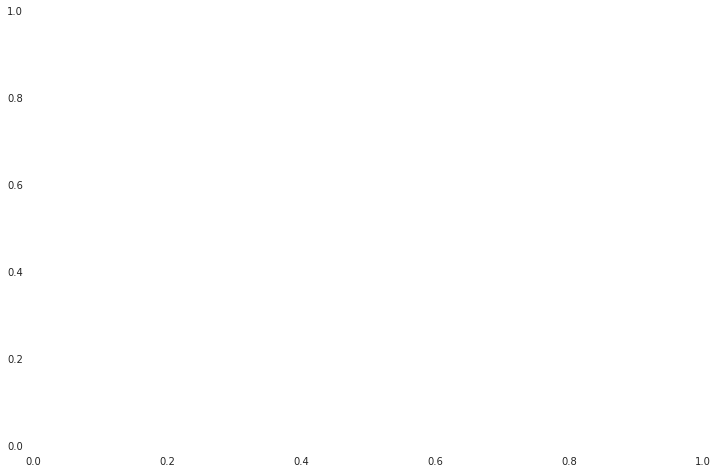

In [145]:
## Influence plot
from statsmodels.graphics.regressionplots import *
fig, ax = plt.subplots(figsize=(12,8))
fig =influence_plot(results, ax=ax)
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/reg_influenceplot.png')

In [146]:
data_agg.shape 

(11600, 15)

In [147]:
pays = list(data_atyp_agg['nom_pays'])
data_perf = data_agg[~data_agg.nom_pays.isin(pays)]
data_perf.shape 

(8800, 15)

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.


In [ ]:
influence = results.get_influence().summary_frame()
data_agg['dcooks']=influence['cooks_d']
seuil_dcook = 4/(n-p)

In [ ]:
atyp_cook = data_agg.loc[np.abs(data_agg['dcooks']) > seuil_dcook]
atyp_cook_pays = atyp_cook.groupby(['nom_pays']).mean().reset_index()

Le seuil de la distance de Cook est de n-p. 

On peut détecter les observations influentes comme ceci :

In [ ]:
plt.figure(figsize=(18,8))
plt.bar(atyp_cook_pays['nom_pays'], atyp_cook_pays['dcooks'])
plt.xticks(np.arange(0, len(atyp_cook_pays), step=1),rotation = 70)
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, len(atyp_cook_pays)], [seuil_dcook, seuil_dcook], color='r')
plt.show()

### Conditions de validité du modele

#### Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [148]:
variables = results.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1454292371708412, 1.1454292371708388, 0.9999999999999996]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [149]:
#matrice des corrélations avec scipy
mc = np.corrcoef(X,rowvar = 0)
print(mc)

[[            nan             nan             nan             nan]
 [            nan  1.00000000e+00 -3.56321256e-01 -1.29489551e-17]
 [            nan -3.56321256e-01  1.00000000e+00  3.29611009e-17]
 [            nan -1.29489551e-17  3.29611009e-17  1.00000000e+00]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [150]:
#règle de Klein
mc2 = mc**2
print(mc2)

[[           nan            nan            nan            nan]
 [           nan 1.00000000e+00 1.26964838e-01 1.67675437e-34]
 [           nan 1.26964838e-01 1.00000000e+00 1.08643418e-33]
 [           nan 1.67675437e-34 1.08643418e-33 1.00000000e+00]]


In [151]:
#critère VIF
vif = np.linalg.inv(mc)
print(vif)

[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


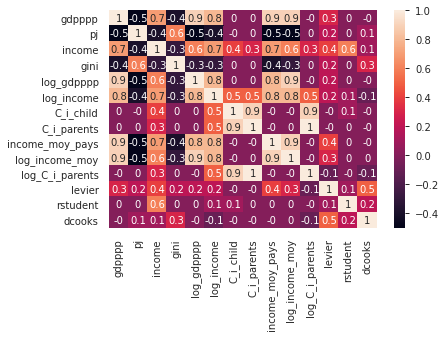

In [152]:
#etude de la correlation
matrice_corr = data_agg.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)


#### Testez l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [153]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(results.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 5.627027999422367e-78


La p-valeur ici est inférieure à  5 %, on  rejette  l'hypothèse  H0  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

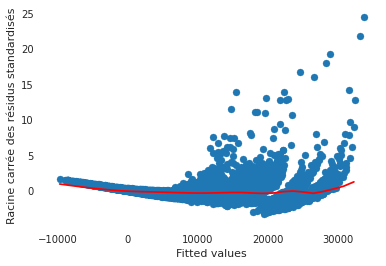

In [154]:
##sqrt_residues_std = np.sqrt(abs(residues_std)) # ne fonctionne pas si on ne met pas abs
sqrt_residues_std = results.get_influence().resid_studentized_internal
fitted_values =  results.predict(X)
from matplotlib.pyplot import plot, scatter, show, xlabel, ylabel
scatter(fitted_values,sqrt_residues_std)
xlabel("Fitted values")
ylabel("Racine carrée des résidus standardisés")
# en reprenant la fonction smooth() plus haut
xs , ys = smooth(fitted_values,sqrt_residues_std,box_percent=0.25,res=30)
plot(xs,ys,"-r")
show()

####1) Les individus sont indépendantes


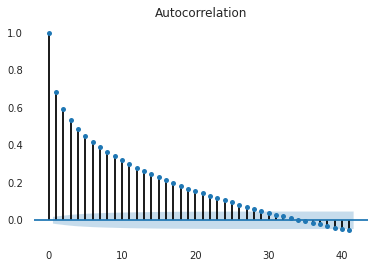

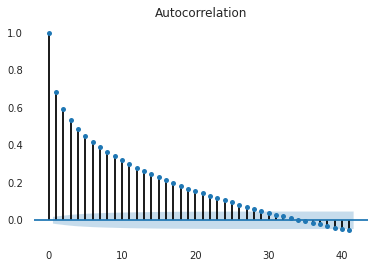

In [155]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(res)

#### 2) Les résidus suivent une distribution normale ( Shapiro )

In [156]:
## Test de shapiro
st.shapiro(res_pearson)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.5726522207260132, 0.0)

In [157]:
## Test de kolmogorov
ks_2samp(results.resid,list(np.random.normal(np.mean(res), np.std(res), len(data_agg))))

Ks_2sampResult(statistic=0.1831896551724138, pvalue=1.7367414979060246e-169)

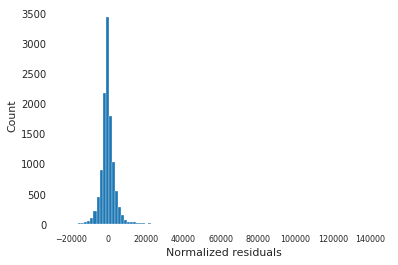

In [158]:
##Visualisation
plt.hist(res,100)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.xticks(fontsize=8)
plt.show()

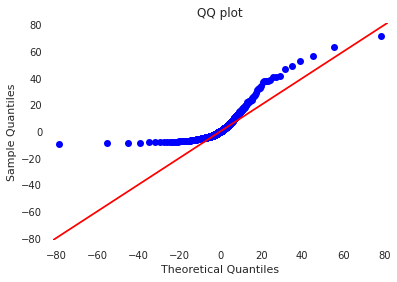

In [159]:
## QQ plot
residues_std = results.get_influence().resid_studentized_internal
fig = sm.qqplot(residues_std, st.t, fit=True,line='45')
plt.title("QQ plot")
plt.show()

##  4. Regression Gini + gdpppp+ C_i_parents LOG (la plus pertinente)

In [160]:
## regression multiple
X = data_agg[['gini',"log_income_moy",'C_i_parents']]
X = sm.add_constant(X)
y = data_agg['log_income']
model = sm.OLS(y,X) ## statsmodels.formula.api.ols('income ~ gini + gdpppp', data=data_agg)
results = model.fit()
res = results.resid ## residues standard
res_pearson = results.resid_pearson ## residues standard de pearson
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.324e+05
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:56:08   Log-Likelihood:                 457.69
No. Observations:               11600   AIC:                            -907.4
Df Residuals:                   11596   BIC:                            -878.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1283      0.022    -95.

In [161]:
## Autre methode de regression
model2=statsmodels.formula.api.ols('log_income ~ gini + log_income_moy  + C_i_parents', data=data_agg)
results_anov = model2.fit()
# Anova sur les variables de notre régression linéaire
anova = sm.stats.anova_lm(results_anov)
anova

df        sum_sq       mean_sq              F  PR(>F)
gini                1.0   2331.765417   2331.765417   43080.495489     0.0
log_income_moy      1.0  13792.617670  13792.617670  254825.292046     0.0
C_i_parents         1.0   5373.012278   5373.012278   99269.004319     0.0
Residual        11596.0    627.642544      0.054126            NaN     NaN

In [162]:
# Calcul des r2 pour chaque variables
rsqrt_gini = anova.sum_sq[anova.index[0]] / anova['sum_sq'].sum()
rsqrt_gdppp = anova.sum_sq[anova.index[1]] / anova['sum_sq'].sum()   
rsqrt_C_i_parents = anova.sum_sq[anova.index[2]] / anova['sum_sq'].sum()

In [163]:
## Conclusion
print('{}% de la variabilité du modele est expliqué par les variables {}'.format(round(results.rsquared *100,2),X.columns.values.tolist()))
print('La variable {} explique {}% de la variance de income '.format(anova.index[0],round(rsqrt_gini*100,2)))
print('La variable {} explique {}% de la variance de income '.format(anova.index[1],round(rsqrt_gdppp*100,2)))
print('La variable {} explique {}% de la variance de income '.format(anova.index[2],round(rsqrt_C_i_parents*100,2)))

97.16% de la variabilité du modele est expliqué par les variables ['const', 'gini', 'log_income_moy', 'C_i_parents']
La variable gini explique 10.54% de la variance de income 
La variable log_income_moy explique 62.34% de la variance de income 
La variable C_i_parents explique 24.28% de la variance de income 


### **Performance du modele**

In [164]:
## Parametre 
alpha = 0.05
n = X.shape[0]
p = len(X.columns.values.tolist())

#### Calculez les leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [165]:
 ## Creation d'une colonne levier 
data_agg['levier'] = results.get_influence().hat_matrix_diag
## Calcul du seuil
seuil_levier = 2*p/n
## Creation des variables 
atyp_levier = data_agg.loc[data_agg['levier'] > seuil_levier]
atyp_levier_pays = atyp_levier.groupby(['nom_pays']).mean().reset_index()
## Affichage du nombre d'individu
print('{} individu ont des leviers supérieurs aux seuil de {}'.format(len(atyp_levier),round(seuil_levier,6)))
## Affichage du nombre de pays concerné 
print('{} pays ont des leviers supérieurs aux seuil de {}'.format(len(atyp_levier_pays),round(seuil_levier,6)))


636 individu ont des leviers supérieurs aux seuil de 0.00069
61 pays ont des leviers supérieurs aux seuil de 0.00069


In [166]:
atyp_levier_pays.sort_values(by='levier',ascending=False)

nom_pays    gdpppp     pj  ...    levier  rstudent    dcooks
0       Afrique du Sud   9602.00  0.677  ...  0.001289  0.000080  0.001333
12            Colombie   8185.00  1.095  ...  0.000948  0.314024  0.000845
19           Guatemala   4367.00  1.015  ...  0.000926  0.340811  0.000826
59            Équateur   7560.00  1.030  ...  0.000911  0.648239  0.000666
44              Panama  11767.00  0.967  ...  0.000910  0.753542  0.000770
..                 ...       ...    ...  ...       ...       ...       ...
25              Italie  28170.00  0.488  ...  0.000719  3.782395  0.000708
41               Népal   1048.18  0.436  ...  0.000713  1.132982  0.000330
3              Arménie   5611.00  0.400  ...  0.000706  0.951934  0.000417
29          Luxembourg  73127.00  0.381  ...  0.000705  5.986950  0.000552
51  République tchèque  23223.00  0.434  ...  0.000702  3.704785  0.000443

[61 rows x 15 columns]

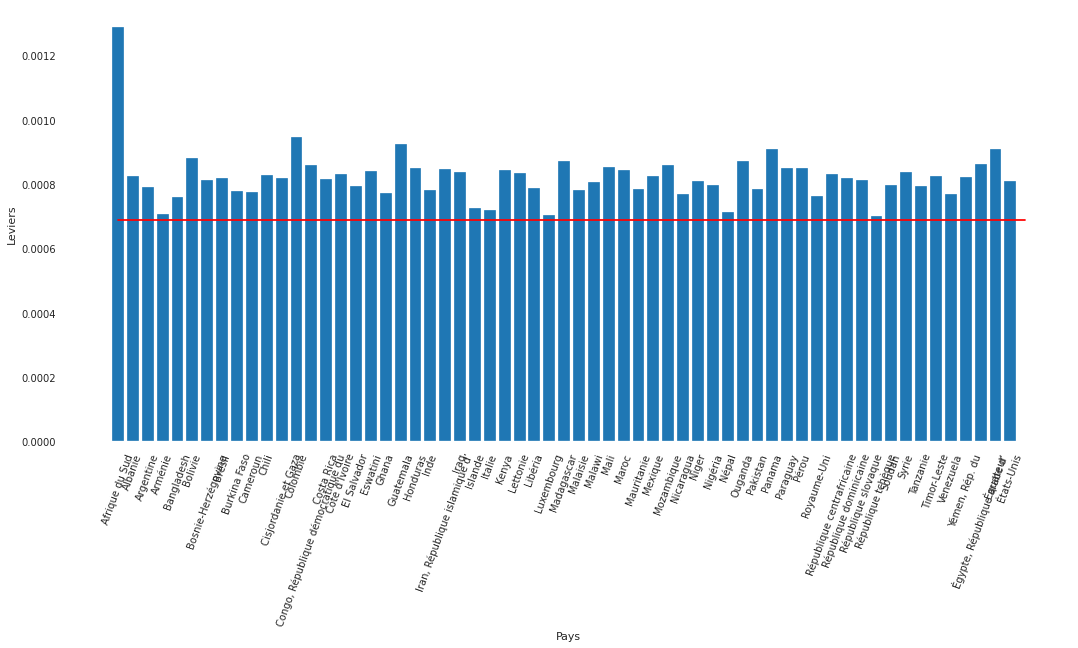

In [167]:
## Graphique
plt.figure(figsize=(18,8))
plt.bar(atyp_levier_pays['nom_pays'],atyp_levier_pays['levier'])
plt.xticks(np.arange(0, len(atyp_levier_pays), step=1),rotation=70)
plt.xlabel('Pays')
plt.ylabel('Leviers')
plt.plot([0, len(atyp_levier_pays)], [seuil_levier, seuil_levier], color='r')
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/reg_leviers.png')
plt.show()

#### Calculez les résidus studentisés

In [168]:
## Création d'une colonne des residus studentisés
data_agg['rstudent'] = results.get_influence().resid_studentized_internal
## Seuil = loi de student a n-p-1 degrés de liberté
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
## Création des variables
atyp_stud = data_agg.loc[np.abs(data_agg['rstudent']) > seuil_rstudent]
atyp_stud_pays = atyp_stud.groupby(['nom_pays']).mean().reset_index()
## Affichage du nombre d'individu
print('{} individu ont des résidus supérieurs aux seuil de {}'.format(len(atyp_stud),round(seuil_rstudent,6)))
## Affichage du nombre de pays concerné 
print('{} pays ont des résidus supérieurs aux seuil de {}'.format(len(atyp_stud_pays),round(seuil_rstudent,6)))

591 individu ont des résidus supérieurs aux seuil de 1.960169
92 pays ont des résidus supérieurs aux seuil de 1.960169


In [169]:
## Affichage
atyp_stud_pays

nom_pays   gdpppp     pj  ...    levier  rstudent    dcooks
0                Afrique du Sud   9602.0  0.677  ...  0.001401 -0.818834  0.002713
1                       Albanie   7297.0  0.816  ...  0.000482 -0.049415  0.000054
2                     Allemagne  33758.0  0.238  ...  0.000385 -0.795387  0.000384
3                     Argentine  13220.0  0.660  ...  0.000821 -1.176510  0.000731
4                      Autriche  36193.0  0.245  ...  0.000455 -0.083877  0.000509
..                          ...      ...    ...  ...       ...       ...       ...
87                     Viet Nam   2578.0  0.480  ...  0.000551  3.019586  0.000435
88               Yémen, Rép. du   2224.0  0.660  ...  0.000752  2.088486  0.000415
89  Égypte, République arabe d’   5011.0  0.943  ...  0.000475  0.171560  0.000046
90                     Équateur   7560.0  1.030  ...  0.001225 -0.472020  0.001620
91                   États-Unis  43261.0  0.538  ...  0.000877 -2.650189  0.001711

[92 rows x 15 columns]

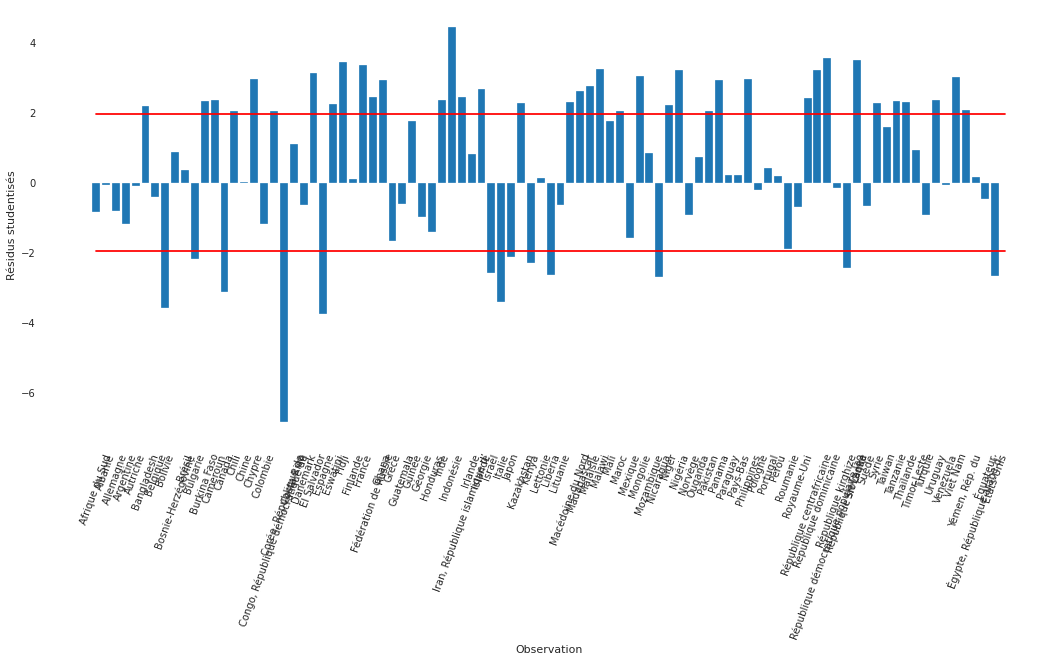

In [170]:
## Graphique 
plt.figure(figsize=(18,8))
plt.bar(atyp_stud_pays['nom_pays'], atyp_stud_pays['rstudent'])
plt.xticks(np.arange(0, len(atyp_stud_pays), step=1),rotation=70)
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, len(atyp_stud_pays)], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, len(atyp_stud_pays)], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/reg_residus_student.png')
plt.show()

#### Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [171]:
## Calcul des distances de cooks
influence = results.get_influence().summary_frame()
data_agg['dcooks']=influence['cooks_d']
## Seuil de cook
seuil_dcook = 4/(n-p)
## Variable contenant les pays ciblé
atyp_cook = data_agg.loc[np.abs(data_agg['dcooks']) > seuil_dcook]
atyp_cook_pays = atyp_cook.groupby(['nom_pays']).mean().reset_index()

Le seuil de la distance de Cook est de n-p. 

On peut détecter les observations influentes comme ceci :

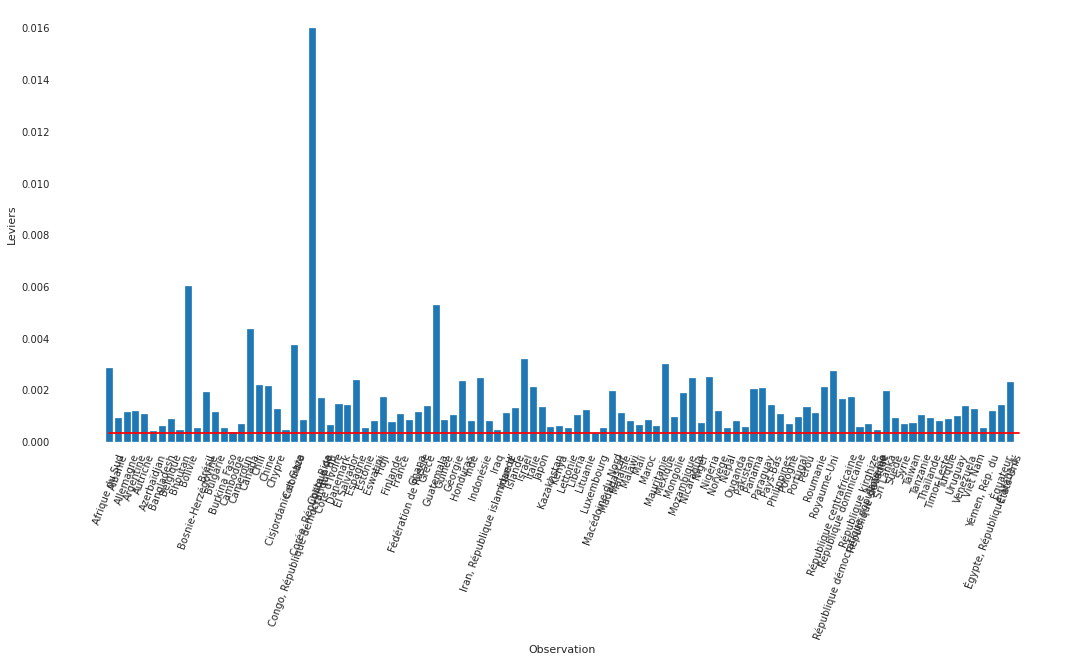

797 individu ont des distances supérieurs aux seuil de 0.000345
103 pays ont des distances supérieurs aux seuil de 0.000345


In [172]:
plt.figure(figsize=(18,8))
plt.bar(atyp_cook_pays['nom_pays'], atyp_cook_pays['dcooks'])
plt.xticks(np.arange(0, len(atyp_cook_pays), step=1),rotation = 70)
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, len(atyp_cook_pays)], [seuil_dcook, seuil_dcook], color='r')
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/Représentation des revenus par quantile.png')
plt.show()
## Affichage du nombre d'individu
print('{} individu ont des distances supérieurs aux seuil de {}'.format(len(atyp_cook),round(seuil_dcook,6)))
## Affichage du nombre de pays concerné 
print('{} pays ont des distances supérieurs aux seuil de {}'.format(len(atyp_cook_pays),round(seuil_dcook,6)))

#### Individus atypiques et influents

In [173]:
## Variables contnant les pays
atyp_cook = data_agg.loc[np.abs(data_agg['dcooks']) > seuil_dcook]
atyp_stud = data_agg.loc[np.abs(data_agg['rstudent']) > seuil_rstudent]
atyp_levier = data_agg.loc[data_agg['levier'] > seuil_levier]

In [174]:
## Pays atypique et influents
data_atyp = data_agg.loc[(np.abs(data_agg['dcooks']) > seuil_dcook) & (np.abs(data_agg['rstudent']) > seuil_rstudent) & (data_agg['levier'] > seuil_levier)]

In [175]:
data_atyp_agg = data_atyp.groupby(['nom_pays']).mean().reset_index()

In [176]:
data_atyp_agg

nom_pays    gdpppp  ...  rstudent    dcooks
0                      Afrique du Sud   9602.00  ... -0.818834  0.004378
1                             Albanie   7297.00  ...  0.474652  0.001765
2                           Argentine  13220.00  ... -1.176510  0.001453
3                          Bangladesh   1233.00  ...  2.178489  0.000918
4                             Bolivie   3950.00  ... -3.582698  0.007792
5                  Bosnie-Herzégovine   7472.00  ...  0.786020  0.000867
6                              Brésil   9559.00  ...  0.378426  0.003085
7                        Burkina Faso   1085.51  ...  2.333951  0.001146
8                            Cameroun   2007.00  ...  2.921281  0.001690
9                               Chili  13390.00  ...  2.055776  0.004238
10                           Colombie   8185.00  ... -1.162609  0.005711
11  Congo, République démocratique du    303.19  ...  2.060884  0.001283
12                         Costa Rica  10374.00  ...  1.123842  0.002156
13                        El Salvador   6270.00  ...  3.132180  0.002116
14                           Eswatini   4748.00  ...  2.252637  0.001243
15                              Ghana   1380.12  ...  2.931600  0.001669
16                          Guatemala   4367.00  ... -0.598849  0.006916
17                           Honduras   3628.00  ... -1.395017  0.003503
18                               Inde   2796.00  ...  2.537352  0.001209
19      Iran, République islamique d’  10446.00  ...  2.453274  0.001283
20                            Islande  36527.00  ...  2.687636  0.001301
21                             Italie  28170.00  ... -3.411821  0.002141
22                              Kenya   1429.00  ... -2.277733  0.001237
23                            Libéria    372.00  ... -2.623149  0.001688
24                         Madagascar    950.00  ...  2.638027  0.001958
25                           Malaisie  13163.00  ...  3.568962  0.002500
26                             Malawi    728.81  ...  3.257717  0.002533
27                               Mali    929.53  ...  2.561886  0.001352
28                              Maroc   3973.00  ...  2.860761  0.001740
29                            Mexique  13434.00  ... -1.501905  0.004538
30                         Mozambique    773.00  ...  0.866553  0.002621
31                          Nicaragua   2576.00  ... -2.408928  0.005119
32                              Niger    631.00  ...  2.219154  0.001017
33                            Nigéria   1946.00  ...  3.214205  0.002506
34                            Ouganda   1067.00  ...  2.766208  0.001583
35                           Pakistan   2335.00  ...  2.053066  0.000814
36                             Panama  11767.00  ...  2.934086  0.002857
37                           Paraguay   4347.00  ...  0.221945  0.003342
38                              Pérou   7858.00  ...  0.194166  0.001757
39                        Royaume-Uni  34048.00  ... -0.702066  0.002120
40          République centrafricaine    685.00  ...  2.436325  0.004336
41             République dominicaine   7505.00  ...  3.236513  0.002666
42                République slovaque  20515.00  ... -2.799399  0.001460
43                              Syrie   4512.00  ...  2.285135  0.001092
44                           Tanzanie   1201.00  ...  2.335888  0.001057
45                        Timor-Leste   1113.13  ...  3.009360  0.001917
46                          Venezuela  11756.00  ... -0.055495  0.001381
47                     Yémen, Rép. du   2224.00  ...  2.131440  0.000979
48        Égypte, République arabe d’   5011.00  ...  1.241958  0.002616
49                           Équateur   7560.00  ... -0.472020  0.002926
50                         États-Unis  43261.00  ... -2.650189  0.003807

[51 rows x 15 columns]

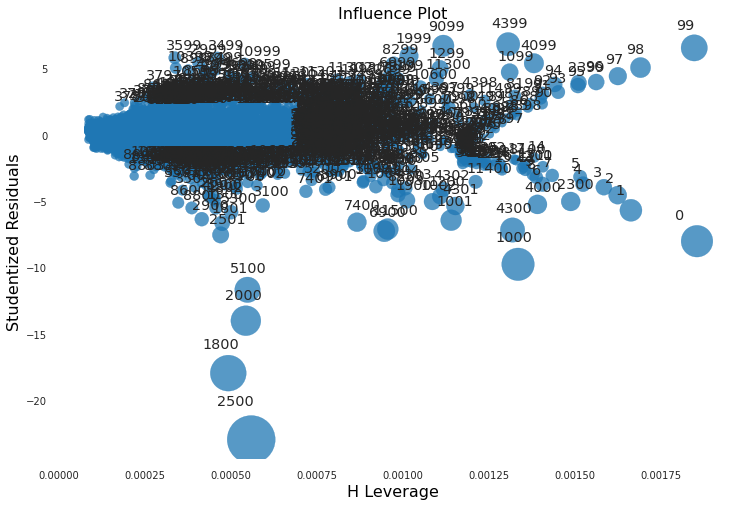

In [177]:
## Influence plot
from statsmodels.graphics.regressionplots import *
fig, ax = plt.subplots(figsize=(12,8))
fig =influence_plot(results, ax=ax)
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/reg_influenceplot.png')

In [178]:
data_agg.shape 

(11600, 15)

In [179]:
pays = list(data_atyp_agg['nom_pays'])
data_perf = data_agg[~data_agg.nom_pays.isin(pays)]
data_perf.shape 

(6500, 15)

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.


### Conditions de validité du modele

#### Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [180]:
variables = results.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0768345416408123, 1.0768345416408145, 0.9999999999999998]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [181]:
#matrice des corrélations avec scipy
mc = np.corrcoef(X,rowvar = 0)
print(mc)

[[            nan             nan             nan             nan]
 [            nan  1.00000000e+00 -2.67118375e-01 -1.29489551e-17]
 [            nan -2.67118375e-01  1.00000000e+00  1.57709924e-17]
 [            nan -1.29489551e-17  1.57709924e-17  1.00000000e+00]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [182]:
#règle de Klein
mc2 = mc**2
print(mc2)

[[           nan            nan            nan            nan]
 [           nan 1.00000000e+00 7.13522261e-02 1.67675437e-34]
 [           nan 7.13522261e-02 1.00000000e+00 2.48724202e-34]
 [           nan 1.67675437e-34 2.48724202e-34 1.00000000e+00]]


In [183]:
#critère VIF
vif = np.linalg.inv(mc)
print(vif)

[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]



#### Testez l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [184]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(results.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 6.266464344428794e-14


La p-valeur ici est inférieure à  5 %, on  rejette  l'hypothèse  H0  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

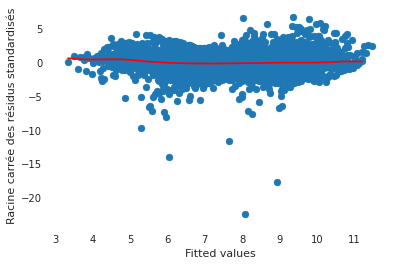

In [185]:
##sqrt_residues_std = np.sqrt(abs(residues_std)) # ne fonctionne pas si on ne met pas abs
sqrt_residues_std = results.get_influence().resid_studentized_internal
fitted_values =  results.predict(X)
from matplotlib.pyplot import plot, scatter, show, xlabel, ylabel
scatter(fitted_values,sqrt_residues_std)
xlabel("Fitted values")
ylabel("Racine carrée des résidus standardisés")
# en reprenant la fonction smooth() plus haut
xs , ys = smooth(fitted_values,sqrt_residues_std,box_percent=0.25,res=30)
plot(xs,ys,"-r")
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/reg_homoscédasticité.png')
show()

####1) Les individus sont indépendantes


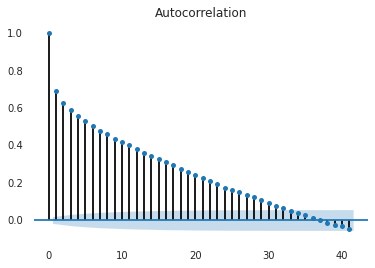

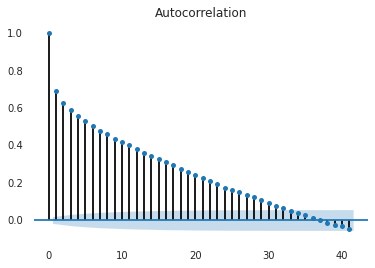

In [186]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(res)

#### 2) Les résidus suivent une distribution normale ( Shapiro )

In [187]:
## Test de shapiro
st.shapiro(res_pearson)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.8496061563491821, 0.0)

In [188]:
## Test de kolmogorov
ks_2samp(results.resid,list(np.random.normal(np.mean(res), np.std(res), len(data_agg))))

Ks_2sampResult(statistic=0.10250000000000004, pvalue=2.3576305471564867e-53)

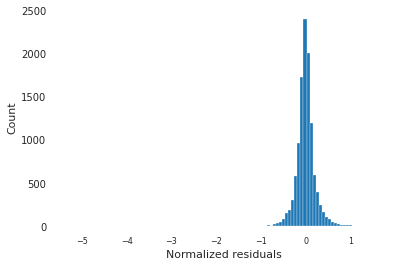

In [189]:
##Visualisation
plt.hist(res,100)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.xticks(fontsize=8)
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/reg_normalplot.png')
plt.show()

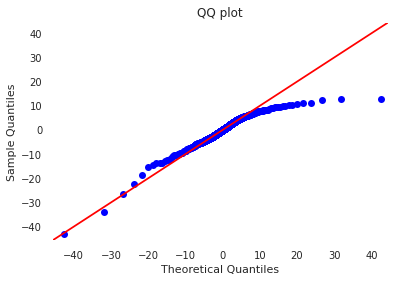

In [190]:
## QQ plot
residues_std = results.get_influence().resid_studentized_internal
fig = sm.qqplot(residues_std, st.t, fit=True,line='45')
plt.title("QQ plot")
plt.savefig('/content/drive/My Drive/DataAnalyst/P7_Muller_Gauthier/rendu/reg_qqplot.png')
plt.show()